In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import wcs
from astropy.io import ascii
from astropy.table import Table, Column, MaskedColumn
from pathlib import Path
from math import trunc
from scipy import optimize
import copy
%matplotlib inline


SMALL_SIZE = 10*2                                        
MEDIUM_SIZE = 12*2
BIGGER_SIZE = 14*2

plt.rc('font', size=SMALL_SIZE, family='serif')          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)                     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)                    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE, direction='in')    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE, direction='in')    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)                    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)                  # fontsize of the figure title
plt.rc('figure', figsize='8, 6')                         # size of the figure, used to be '4, 3' in inches

In [2]:
# Retreive all the data from the meta-data file
meta_data = ascii.read('../datared/J0600_meta-data.txt')

# To get nice plots, all the data is sorted by the epoch
epoch_tmp = np.array(meta_data["EPOCH"])
sort = np.argsort(epoch_tmp)
epoch_arr = epoch_tmp[sort]

filters = np.array(meta_data["FILTER"])[sort] # Filters of all the .fits images
airmass_arr = np.array(meta_data["AIRMASS"])[sort] # Airmasses for all the .fits images

fits_name_arr = np.array(meta_data["IMAGE"])[sort] # Name of the original .fits file
files_arr = np.array(meta_data["NEWIMG"])[sort] # Name of the data reduced files

N_files = len(epoch_arr) #nr of files
N_stars = len(ascii.read(files_arr[0])["STARNR"]) - 1 #nr of stars
print ("Number of files = {}".format(N_files))
print ("Number of stars = {}".format(N_stars))

Number of files = 1762
Number of stars = 160


In [3]:
# Make a mask for all the filters:
filt = [] #list of the different filters
NimgINf = {} #dictionary of number of images for each filter
for f in filters:
    if f not in filt:
        filt.append(f)
        NimgINf[f] = 1
    else:
        NimgINf[f] +=1
print (filt)
print (NimgINf)

fmask = {}
for f in filt:
    fmask[f] = filters == f

    
# Retreive the flux and fluxerr data from all the other files
flux_tmp = np.zeros((N_files,N_stars+1))
fluxerr_tmp = np.zeros((N_files,N_stars+1))

for i in range(N_files):
    file = files_arr[i]
    
    filecontent = ascii.read(file)
    flux_tmp[i] = np.array(filecontent["FLUX"])
    fluxerr_tmp[i] = np.array(filecontent["FLUXERR"])

print (np.shape(flux_tmp))
print (np.shape(fluxerr_tmp))


# Make a dictionary where flux[filter] gives an array with all the data for that filter
# And do the same for epoch, airmass, fits_name and files
J0600_flux = {}
J0600_fluxerr = {}

flux = {}
fluxerr = {}

epoch = {}
airmass = {}
fits_name = {}
files = {}

rawepoch = {} #remove later, just a test

for f in filt:
    J0600_flux[f] = flux_tmp[fmask[f]][:,0]
    J0600_fluxerr[f] = fluxerr_tmp[fmask[f]][:,0]
    
    flux[f] = flux_tmp[fmask[f]][:,1:]
    fluxerr[f] = fluxerr_tmp[fmask[f]][:,1:]
    
    epoch[f] = epoch_arr[fmask[f]]
    airmass[f] = airmass_arr[fmask[f]]
    fits_name[f] = fits_name_arr[fmask[f]]
    files[f] = files_arr[fmask[f]]
    
    rawepoch[f] = copy.copy(epoch[f]) #remove later, just a test


#Before 20-04 this outputs:
#['gp', 'I', 'V', 'B', 'ip', 'up', 'rp']
#{'gp': 769, 'I': 1, 'V': 1, 'B': 1, 'ip': 630, 'up': 36, 'rp': 324}
#(1762, 161)
#(1762, 161)

['gp', 'I', 'V', 'B', 'ip', 'up', 'rp']
{'gp': 769, 'I': 1, 'V': 1, 'B': 1, 'ip': 630, 'up': 36, 'rp': 324}
(1762, 161)
(1762, 161)


In [4]:
# I want to exclude the I, V, B and 'up' filter so I do that here:
filt = ['gp', 'rp', 'ip']

# Remove epochs with 80% NaN values

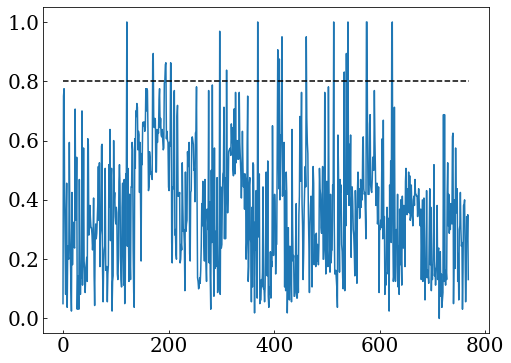

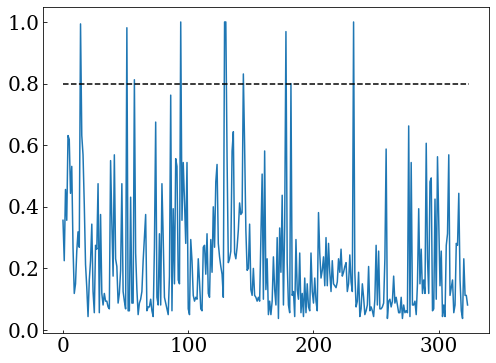

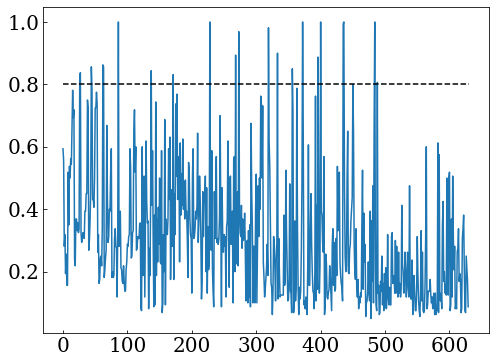

In [5]:
maxnan_epoch = 0.80
ge_mask = {}

for f in filt:
    good_epoch_mask = np.sum(np.isnan(flux[f]),axis=1)/len(flux[f][0]) < maxnan_epoch
    ge_mask[f] = good_epoch_mask #remove later
    
    plt.plot(np.sum(np.isnan(flux[f]),axis=1)/len(flux[f][0]))
    plt.plot([0,len(flux[f][:,0])],[maxnan_epoch]*2,c='black',linestyle='--')
    plt.show()
    
    J0600_flux[f] = J0600_flux[f][good_epoch_mask]
    J0600_fluxerr[f] = J0600_fluxerr[f][good_epoch_mask]
    
    flux[f] = flux[f][good_epoch_mask]
    fluxerr[f] = fluxerr[f][good_epoch_mask]
    
    epoch[f] = epoch[f][good_epoch_mask]
    airmass[f] = airmass[f][good_epoch_mask]
    fits_name[f] = fits_name[f][good_epoch_mask]
    files[f] = files[f][good_epoch_mask]
    

In [6]:
#for f in filt:
#    plt.figure(figsize=(12,6))
#    for s in range(len(flux[f][0])):
#        plt.errorbar(epoch[f],flux[f][:,s],yerr=fluxerr[f][:,s],fmt='--.')
#    plt.yscale('log')
#    plt.title("Flux plotted against epoch")
#    plt.xlabel('Epoch (MJD)')
#    plt.ylabel('Flux (counts)')
#    plt.axis(ymax=6e6)
#    plt.show()

# Doing differential photometry for I-band (and maybe more) magnitudes

### Step i)

In [7]:
# Some variables:
N_sigclip = 3 # n_sigma clip
N_sigclip2 = 4 # n_sigma clip on ALC estimate data
pernan_sigclip = 0.20 #percentage nan values after sigclip after which star is no longer selected


# Calculate a median-normalised flux for each star in each image
medflux1 = {}
mednormflux1 = {}
for f in filt:
    medflux1[f] = np.nanmedian(flux[f],axis=0)
    mednormflux1[f] = (flux[f]/medflux1[f])


# Do a 3sigma clipping of the mean-normalised fluxes: if a flux of a star has a 3sigma deviation from the median,
#  its fluxvalue will be set to NaN
sigcl_mask = {}
for f in filt:
    sig = np.nanstd(mednormflux1[f],axis=1)
    med = np.nanmedian(mednormflux1[f],axis=1)
    
    tmp = []
    for e in range(len(epoch[f])):
        mask = np.abs(mednormflux1[f][e]-med[e]) > N_sigclip*sig[e]
        tmp.append(mask)
    sigcl_mask[f] = np.array(tmp)

flux2 = {}
fluxerr2 = {}
mednormflux2 = {}
for f in filt:
    flux2[f] = copy.deepcopy(flux[f])
    fluxerr2[f] = copy.deepcopy(fluxerr[f])
    mednormflux2[f] = copy.deepcopy(mednormflux1[f])
    
    flux2[f][sigcl_mask[f]] = np.NaN
    fluxerr2[f][sigcl_mask[f]] = np.NaN
    mednormflux2[f][sigcl_mask[f]] = np.NaN
    

/home/bartjuh60/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/bartjuh60/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


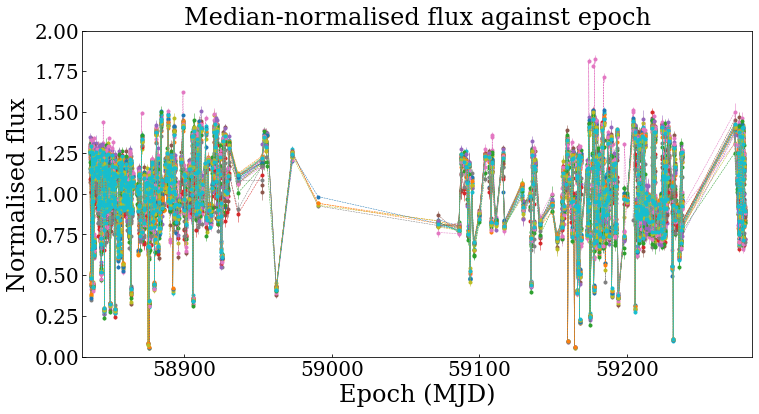

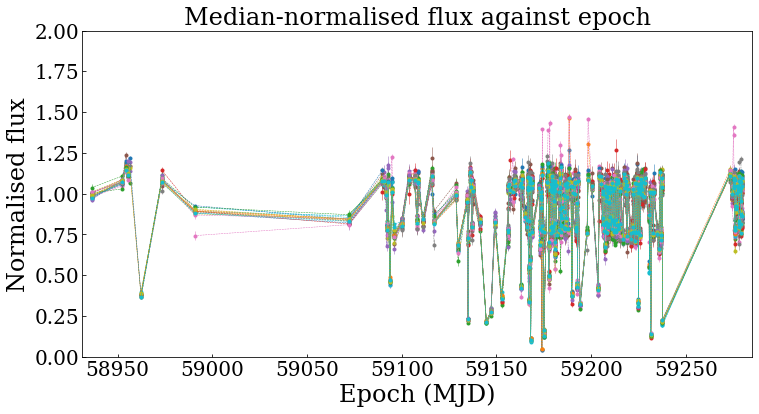

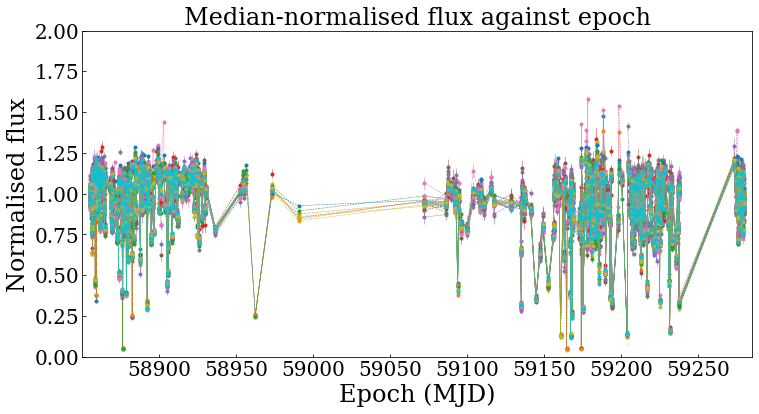

In [8]:
# Check if previous step went well
#for f in filt:
#    plt.plot(epoch[f],mednormflux1[f])
#    plt.show()
#    plt.plot(epoch[f],mednormflux2[f])
#    plt.show()

for f in filt:
    plt.figure(figsize=(12,6))
    for s in np.arange(len(flux[f][0]))[:30]:
        plt.errorbar(epoch[f],flux2[f][:,s]/np.nanmedian(flux2[f][:,s]),
                     yerr=fluxerr2[f][:,s]/np.nanmedian(flux2[f][:,s]),fmt='--.',linewidth=.5)
    plt.title("Median-normalised flux against epoch")
    plt.xlabel('Epoch (MJD)')
    plt.ylabel('Normalised flux')
    plt.axis(ymin=0, ymax=2,xmin=np.min(epoch[f])-5,xmax=5+np.max(epoch[f]))
    plt.show()

### step ii)

Selected stars 70/160 (43.750%)
Selected stars 103/160 (64.375%)
Selected stars 87/160 (54.375%)


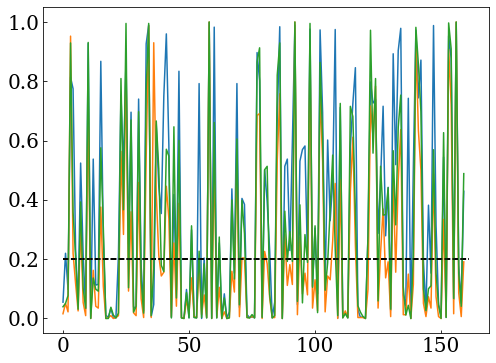

(746, 70)
(314, 103)
(608, 87)


In [9]:
smask = {}
for f in filt:
    nanper_star = np.sum(np.isnan(flux2[f]),axis=0)/len(epoch[f])
    smask[f] = nanper_star < pernan_sigclip #percentage of NaN values above which a star is excluded
    print ("Selected stars {}/{} ({:.3f}%)".format(np.sum(smask[f]),len(smask[f]),
                                                   100*np.sum(smask[f])/len(smask[f])))
    plt.plot(nanper_star)
    plt.plot([0,161],[pernan_sigclip]*2,c='black',linestyle='dashed')
plt.show()

flux3 = {}
fluxerr3 = {}
mednormflux3 = {}
for f in filt:
    flux3[f] = ((flux2[f].transpose())[smask[f]]).transpose()
    fluxerr3[f] = ((fluxerr2[f].transpose())[smask[f]]).transpose()
    mednormflux3[f] = ((mednormflux2[f].transpose())[smask[f]]).transpose()
    print (np.shape(flux3[f]))

In [10]:
# Check if all went well
#for f in filt:
#    plt.plot(np.sum(np.isnan(flux3[f]),axis=0))
#    plt.plot([0,len(flux3[f][0])],[len(flux3[f][:,0])]*2,c='black',linestyle='dashed')
#    plt.show()
#    plt.plot(np.sum(np.isnan(flux3[f]),axis=1))
#    plt.plot([0,len(flux3[f][0:,])],[len(flux3[f][0])]*2,c='black',linestyle='dashed')
#    plt.show()

### Step iii)

In [11]:
initialw = {}
for f in filt:
    initialw[f] = np.nanmedian(flux3[f],axis=0)
    
    
def ALC_func(F,ep, inw, w):
    tmp = []
    
    for e in range(len(ep)):
        noNaN = np.isnan(F[e]) == False
        ALC_i = np.sum(((F[e]*w)/(inw))[noNaN]) / np.sum(w[noNaN])
        tmp.append(ALC_i)
        
    return np.array(tmp)

ALC = {}
for f in filt:
    ALC[f] = ALC_func(flux3[f],epoch[f], initialw[f], initialw[f])

### Step iv)

In [12]:
def weight_func(F, ep, inw, ALC):
    
    w_ij = []
    for e in range(len(ep)):
        w_j = ((F[e]/inw) *(1/(ALC[e])))
        w_ij.append(w_j)
    w_ij = np.array(w_ij)
    
    return (1/np.sqrt(np.nanmean((w_ij-np.nanmean(w_ij,axis=0))**2,axis=0)))**2 


### Step v)

In [13]:
i = 0
weight1 = {}

test = {}
for f in filt:
    test[f] = []

while i < 50:
    i += 1
    
    for f in filt:
        weight1[f] = weight_func(flux3[f],epoch[f],initialw[f],ALC[f])
        test[f].append(weight1[f])
    
    for f in filt:
        ALC[f] = ALC_func(flux3[f],epoch[f], initialw[f], weight1[f])
    


In [14]:
# Check if weights converge within 1e-5


#for f in filt:
#    for i in range(1,40):
#        plt.plot(np.array(test[f][i-1])-np.array(test[f][i]))
        #plt.yscale('log')
    #plt.ylim([-1e-5,1e-5])
#        plt.show()


### Step vi)

In [15]:
from scipy import optimize

def RMS(arr):
    return np.sqrt(np.nanmean((np.nanmean(arr)-arr)**2))

def starRMS_model(F, a,b,c):
    return a*np.sqrt((1/F) + (b/(F**2)) + c)

In [16]:
medflux = {}
for f in filt:
    medflux[f] = np.nanmedian(flux3[f].transpose()/ALC[f],axis=1)
    

RMS_afterALC = {}
for f in filt:
    tmp = []
    for s in range(len(flux3[f][0])):
        tmp.append(RMS((flux3[f][:,s]/ALC[f])/medflux[f][s]))
    RMS_afterALC[f] = np.array(tmp)

fitpar = {}
fitparerr = {}
for f in filt:
    popt, pcov = optimize.curve_fit(starRMS_model, medflux[f],RMS_afterALC[f])#,sigma=(RMS_afterALC[f]))
    fitpar[f] = popt
    fitparerr[f] = np.sqrt(np.diag(pcov))

<ipython-input-15-539780b1a58e>:7: RuntimeWarning: invalid value encountered in sqrt
  return a*np.sqrt((1/F) + (b/(F**2)) + c)


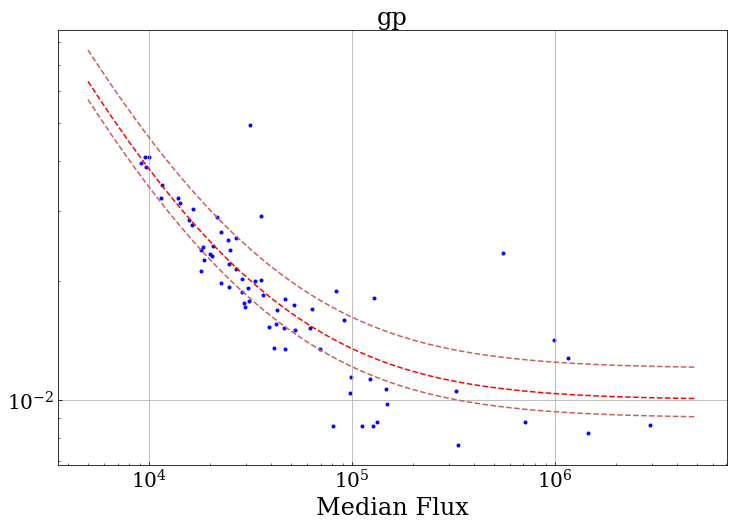

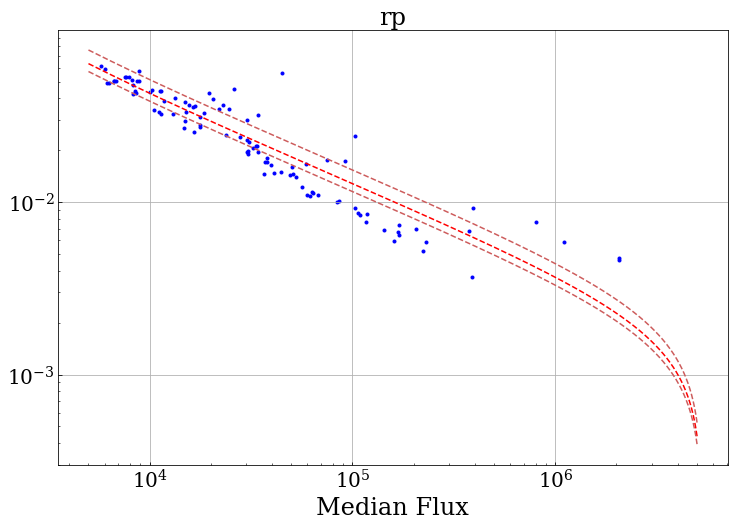

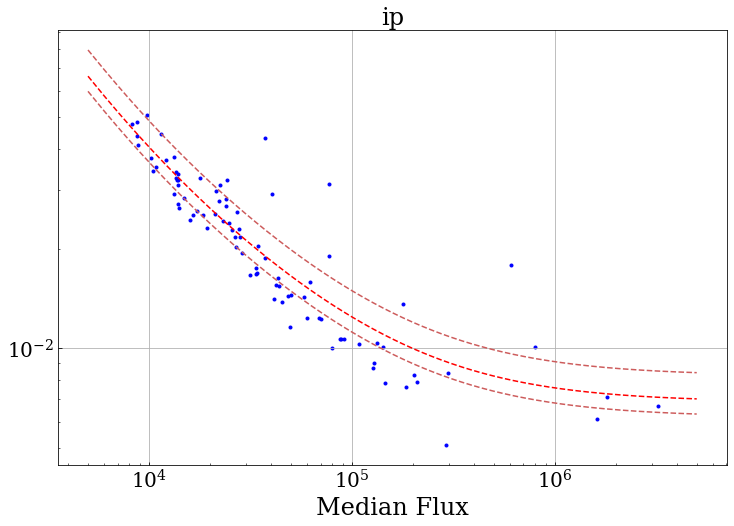

In [17]:
x = np.linspace(5e3,5e6,10000)
for f in filt:
    plt.figure(figsize=(12,8))
    plt.plot(x,starRMS_model(x,*fitpar[f]),c='r',linestyle='dashed')
    plt.plot(x,1.2*starRMS_model(x,*fitpar[f]),c='indianred',linestyle='dashed')
    plt.plot(x,0.9*starRMS_model(x,*fitpar[f]),c='indianred',linestyle='dashed')
    #for s in np.arange(len(newflux[f][0])):
        #plt.scatter(medflux[f][s],RMS_afterALC[f][s],marker='.',label='s')
    #plt.errorbar(medflux[f],RMS_afterALC[f],yerr=(RMS_afterALC[f])**2,fmt='.',c='b')
    plt.scatter(medflux[f],RMS_afterALC[f],marker='.',c='b')
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.yscale('log')
    plt.xscale('log')
    plt.grid()
    plt.xlabel('Median Flux')
    plt.title(f)
    plt.show()

In [18]:
# Reject all points above the 1.2 line and then fit again:
RMS_mask = {}

#the first factors are for < excl_bar[f], the second factor is for > excl_bar[f]
excl_fac1 = {'gp':1,'ip':1,'rp':1.06,'up':1.2}
excl_fac2 = {'gp':.9,'ip':1.2,'rp':3,'up':1.2}
excl_bar = {'gp':1e5,'ip':1e5,'rp':1e6,'up':1e5} #barrier

for f in filt:
    m1 = RMS_afterALC[f] > excl_fac1[f] * starRMS_model(medflux[f], *fitpar[f])
    m2 = medflux[f] < excl_bar[f]
    m3 = RMS_afterALC[f] > excl_fac2[f] * starRMS_model(medflux[f], *fitpar[f])
    m4 = medflux[f] > excl_bar[f]
    
    RMS_mask[f] = ((m1*m2) + (m3*m4)) == False 




<ipython-input-15-539780b1a58e>:7: RuntimeWarning: invalid value encountered in sqrt
  return a*np.sqrt((1/F) + (b/(F**2)) + c)


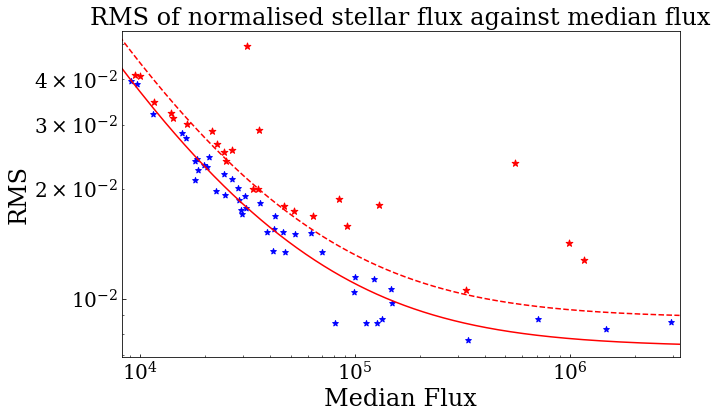

[2.43356066e+00 1.21173124e+04 9.18927702e-06]


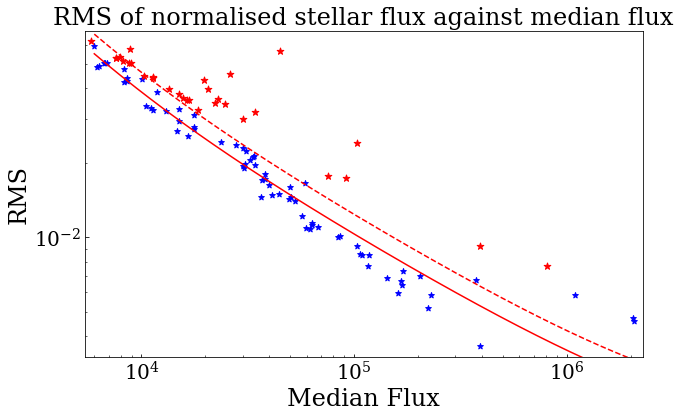

[3.15473365e+00 4.96168071e+03 2.34306211e-07]


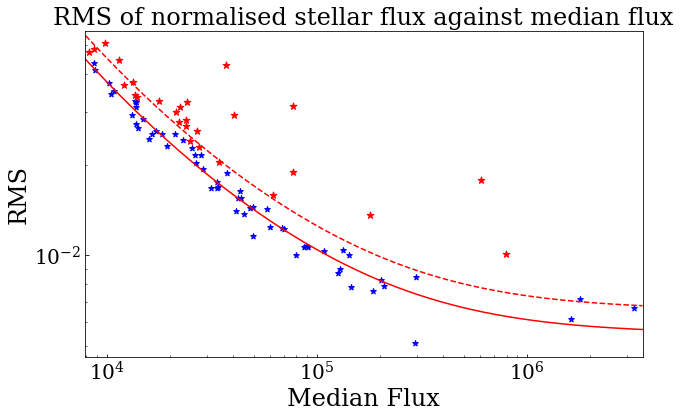

[2.69050129e+00 9.29470069e+03 4.14015934e-06]


In [19]:
fitpar2 = {}
fitparerr2 = {}
for f in filt:
    popt, pcov = optimize.curve_fit(starRMS_model, medflux[f][RMS_mask[f]],RMS_afterALC[f][RMS_mask[f]])#,sigma=(RMS_afterALC[f]))
    fitpar2[f] = popt
    fitparerr2[f] = np.sqrt(np.diag(pcov))

x = np.linspace(6e3,5e6,10000)
for f in filt:
    plt.figure(figsize=(10,6))
    #for i in range(len(J0600_flux[f])):
    #    plt.plot([J0600_flux[f][i]/ALC_final[f][i]]*2,[5e-3,5e-2], c='black')
    plt.plot(x,starRMS_model(x,*fitpar2[f]),c='r',linestyle='-')
    plt.plot(x,1.2*starRMS_model(x,*fitpar2[f]),c='r',linestyle='--')
    #plt.plot(x,starRMS_model(x,*fitpar[f]),c='c',linestyle='-')
    #plt.plot(x,1.2*starRMS_model(x,*fitpar[f]),c='c',linestyle='--')
    plt.scatter(medflux[f][RMS_mask[f]],RMS_afterALC[f][RMS_mask[f]],marker='*',c='b')
    plt.scatter(medflux[f][RMS_mask[f] == False],RMS_afterALC[f][RMS_mask[f] == False],marker='*',c='r',s=50)
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('Median Flux')
    plt.ylabel("RMS")
    plt.title("RMS of normalised stellar flux against median flux")
    plt.xlim([np.min(medflux[f][RMS_mask[f]])*0.9,1.1*np.max(medflux[f][RMS_mask[f]])])
    plt.ylim([np.min(RMS_afterALC[f][RMS_mask[f]])*0.9,1.1*np.max(RMS_afterALC[f][RMS_mask[f] == False])])
    plt.show()
    print (fitpar2[f])

### Step vii)

In [20]:
stdcl2_mask = {}

sigcl2_flux = {}
sigcl2_fluxerr = {}
for f in filt:
    double_normalised_flux = (((flux3[f].T)/ALC[f]).T)/np.nanmedian((((flux3[f].T)/ALC[f]).T),axis=0)
    sig = np.nanstd(double_normalised_flux,axis=1)
    med = np.nanmedian(double_normalised_flux,axis=1)
    
    sigcl2_flux[f] = copy.deepcopy(flux3[f])
    sigcl2_fluxerr[f] = copy.deepcopy(fluxerr3[f])
    for e in range(len(epoch[f])):
        sigclip_mask = np.abs(double_normalised_flux[e]-med[e]) > 4*sig[e]
        print (np.sum(sigclip_mask), len(sigclip_mask))
        sigcl2_flux[f][e][sigclip_mask] = np.NaN
        sigcl2_fluxerr[f][e][sigclip_mask] = np.NaN

0 70
0 70
0 70
1 70
0 70
0 70
1 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
1 70
2 70
0 70
0 70
1 70
0 70
0 70
0 70
0 70
0 70
1 70
0 70
0 70
0 70
0 70
0 70
1 70
1 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
1 70
0 70
0 70
0 70
0 70
0 70
0 70
1 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
1 70
0 70
1 70
1 70
1 70
1 70
0 70
1 70
0 70
0 70
0 70
0 70
0 70
1 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
1 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
1 70
0 70
1 70
1 70
1 70
2 70
0 70
0 70
0 70
1 70
0 70
0 70
0 70
1 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
1 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
1 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
1 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
1 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
1 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
0 70
1 70
0 70
0 70
0 70
1 70
0 70


In [21]:
# Remove stars with more than 20% nan values in their data after sigma_clip 2
nansmask = {}
for f in filt:
    nansmask[f] = np.sum(np.isnan(sigcl2_flux[f]),axis=0)/len(sigcl2_flux[f]) < 0.20

# RMS_mask * nansmask is selecting stars according to RMS model & all the stars with less than 20% nan values
flux4 = {}
fluxerr4 = {}
medflux2 = {}
weight2 = {}
for f in filt:
    flux4[f] = ((flux3[f].T)[RMS_mask[f]*nansmask[f]]).T
    fluxerr4[f] = ((fluxerr3[f].T)[RMS_mask[f]*nansmask[f]]).T
    medflux2[f] = medflux[f][RMS_mask[f]*nansmask[f]]
    weight2[f] = copy.deepcopy(weight1[f][RMS_mask[f]*nansmask[f]])

### Step viii)

In [22]:
ALC_2 = {}

i = 0

test = {}
for f in filt:
    test[f] = []

while i < 30:
    i += 1
    
    for f in filt:
        ALC_2[f] = ALC_func(flux4[f],epoch[f], medflux2[f], weight2[f])
        
    
    for f in filt:
        weight2[f] = weight_func(flux4[f],epoch[f],medflux2[f],ALC_2[f])
        test[f].append(weight2[f])


In [23]:
# check if the weights converge within 1e-5
# -> after ~ 20 iterations

#for f in filt:
#    for i in range(1,30):
#        plt.plot(np.array(test[f][i-1])-np.array(test[f][i]))
        #plt.yscale('log')
#        plt.title(str(i-1) + " - " + str(i))
    #plt.ylim([-1e-5,1e-5])
#        plt.show()

### Step ix)

In [24]:
# To link the correct Gaia entries to our stars, select star with nearest coordinates
def find_stars(xobj_list, yobj_list, xlist, ylist, f):
    # Make a matrix with each column the same xlist or ylist.
    # The number of columns is the number of objects in standards.txt
    xmatrix = np.array(list(xlist)*len(xobj_list)).reshape([len(xobj_list),len(xlist)]).transpose()
    ymatrix = np.array(list(ylist)*len(yobj_list)).reshape([len(yobj_list),len(ylist)]).transpose()
    
    distance_matrix = np.sqrt((xmatrix-xobj_list)**2 + (ymatrix-yobj_list)**2)
    
    indices = np.argmin(distance_matrix, axis=0)
    """
    # Make plot to check data
    plt.figure(figsize=(16,16))
    plt.scatter(xlist,ylist,c='b',s=4)
    plt.scatter(xobj_list, yobj_list, c='red', s=2)
    plt.plot([2000,2025],[0,0],c='r')
    for i in range(nr_stars):
    	plt.plot([xobj_list[i],xlist[indices[i]]],[yobj_list[i],ylist[indices[i]]], linestyle='dashed',c='r',linewidth=1)
    plt.title(f)
    plt.show()
    """
    return indices, np.diag(distance_matrix[indices])
    #the diagonal gives the distance from each selected object to the closest object

def distance(xobj,yobj, xlist,ylist):
    'find the distance between target & objects round it, returns list with distances in pixels'
    d = (xobj-xlist)**2 + (yobj-ylist)**2
    return np.sqrt(d)

def dis_weightfunc(dis, maxdis, a):
    return 1/(1 + ((a*dis)/maxdis)**2)


In [25]:
# Get the stellar coordinates for the selected stars
star_coords = {}
standards = ascii.read('standards.txt')[1:]

# The selected stars can be selected using the mask [smask[f]][RMS_mask[f] * nansmask[f]]
for f in filt:
    tmp1 = np.array(standards[smask[f]][RMS_mask[f] * nansmask[f]]['RA'])
    tmp2 = np.array(standards[smask[f]][RMS_mask[f] * nansmask[f]]['Dec'])
    star_coords[f] = np.array([tmp1,tmp2]).transpose()

d_J0600 = {}
maxd_J0600 = {}
for f in filt:
    # Coords of J0600: 90.00316332976436 -31.007910088843165
    d = distance(90.00316332976436, -31.007910088843165, star_coords[f][:,0], star_coords[f][:,1])
    d_J0600[f] = d
    maxd_J0600[f] = np.max(d)


In [26]:
# Extract the magnitudes from the stars in 400" radius around J0600
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia

# Coords of J0600: 90.00316332976436 -31.007910088843165
coord = SkyCoord(ra=90.003163, dec=-31.007910, unit=(u.degree, u.degree), frame='icrs')
radius = u.Quantity(400, u.arcsec)
Gaia.ROW_LIMIT = -1
j = Gaia.cone_search_async(coord, radius)
r = j.get_results()
r.pprint()

# Making a mask for the gaia data to extract the data from the relevant stars
gaiamask = {}
for f in filt:
    stars_arg, d = find_stars(star_coords[f][:,0],star_coords[f][:,1],np.array(r['ra']),np.array(r['dec']),f)
    gaiamask[f] = stars_arg
    max_d = 1 #if distance is bigger than 1", it is to much
    if np.sum(d >= max_d) != 0:
        print ("Stars that are too distant")
        print (f, np.arange(N_stars)[d >= max_d])
    plt.show()

# Get the gaia-colours for the selected stars in all filters
gaia_c = {}
for f in filt:
    c = np.array(r['phot_rp_mean_mag'][gaiamask[f]]) - np.array(r['phot_g_mean_mag'][gaiamask[f]])
    gaia_c[f] = c

gaia_mag = {}
gaia_mag['gp'] = r['phot_g_mean_mag'][gaiamask['gp']] #gaia filter g, not gp
gaia_mag['rp'] = r['phot_rp_mean_mag'][gaiamask['rp']]

# Extract the Gaia J0600 data
# Coords of J0600: 90.00316332976436 -31.007910088843165
d = distance(90.00316332976436, -31.007910088843165, r['ra'],r['dec'])
J0600_gaia = r[np.argmin(d)]

# Extract gaia magnitudes & colour for J0600
J0600_gaiamag = {}
J0600_gaiamag[filt[0]] = J0600_gaia['phot_g_mean_mag'] #gaia filter g, not gp
J0600_gaiamag[filt[1]] = J0600_gaia['phot_rp_mean_mag']

J0600_c = J0600_gaia['phot_rp_mean_mag']-J0600_gaia['phot_g_mean_mag']


Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
INFO: Query finished. [astroquery.utils.tap.core]
    solution_id             designation          ...          dist         
                                                 ...                       
------------------- ---------------------------- ... ----------------------
1635721458409799680 Gaia DR2 2891196718939580672 ... 0.00013201426578689563
1635721458409799680 Gaia DR2 2891196684579844864 ...   0.009094052279059428
1635721458409799680 Gaia DR2 2891196753298345472 ...   0.010658205399898254
1635721458409799680 Gaia DR2 2891196684579845376 ...   0.011317279008876314
1635721458409799680 Gaia DR2 2891196753297490304 ...   0.012358430209092582
1635721458409799680 Gaia DR2 2891196920800325760 ...   0.013193050363307734
1635721458409799680 Gaia DR2 2891196753299317632 ...   0

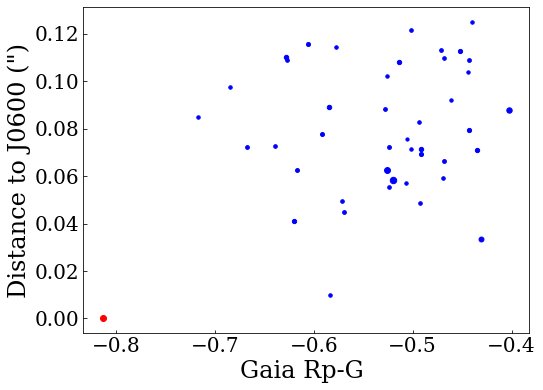

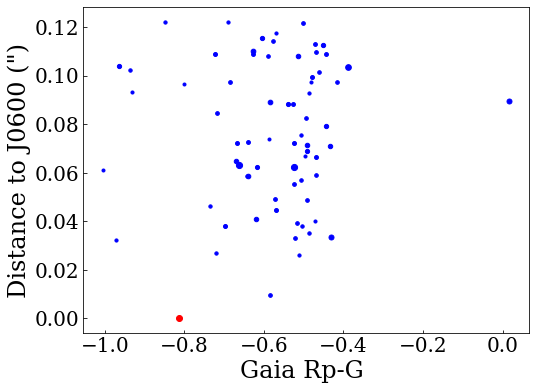

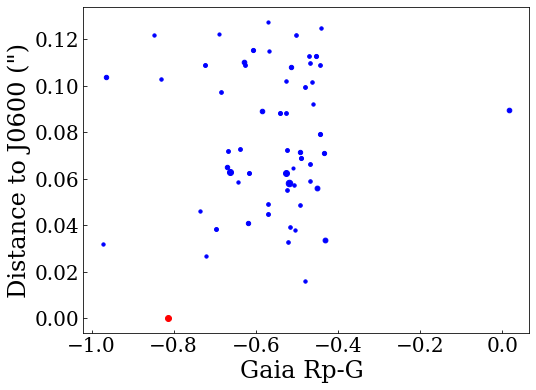

In [27]:
for f in filt:
    for s in range(len(gaia_c[f])):
        plt.scatter(gaia_c[f][s],d_J0600[f][s],c='b',s=1e0*(medflux2[f][s])**(1/4))
    plt.scatter(J0600_c,[0],c='r')
    plt.ylabel("Distance to J0600 (\")")
    plt.xlabel("Gaia Rp-G ")
    plt.show()

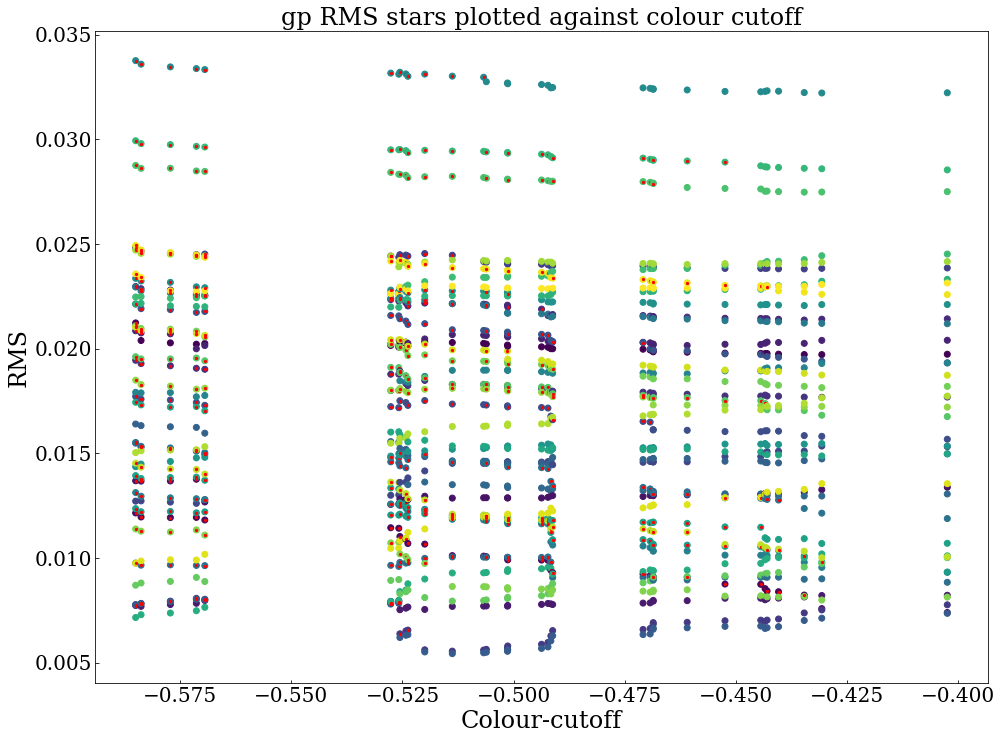

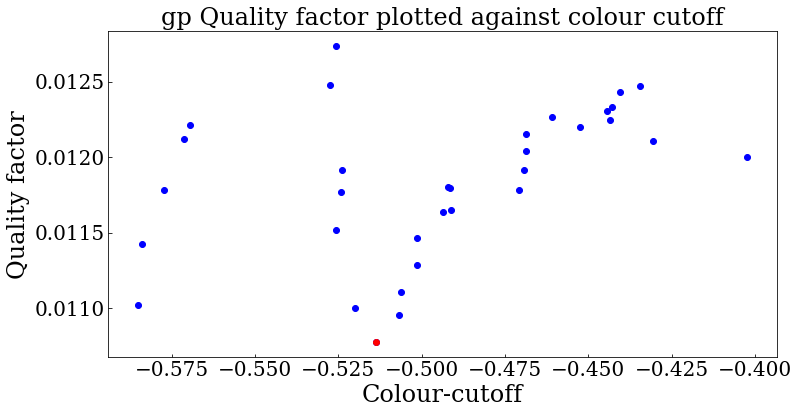

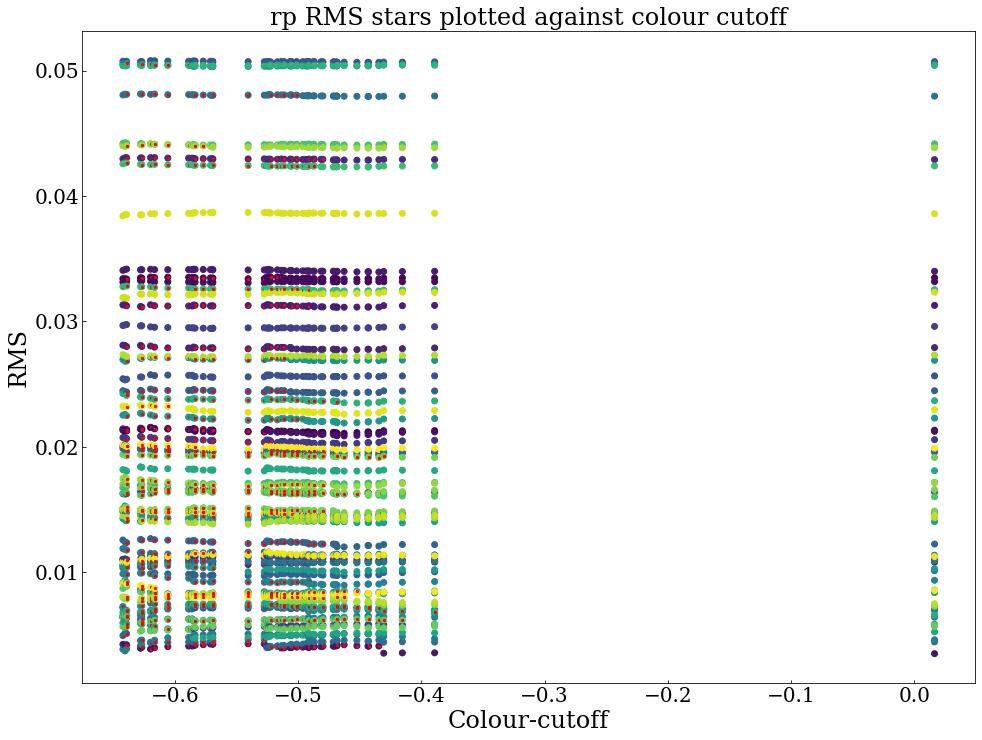

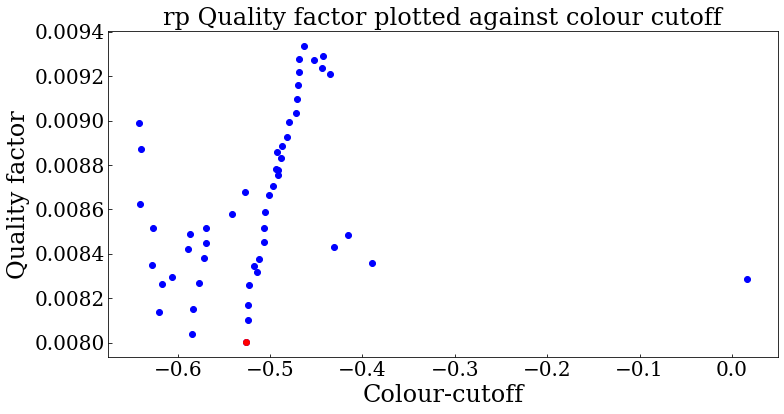

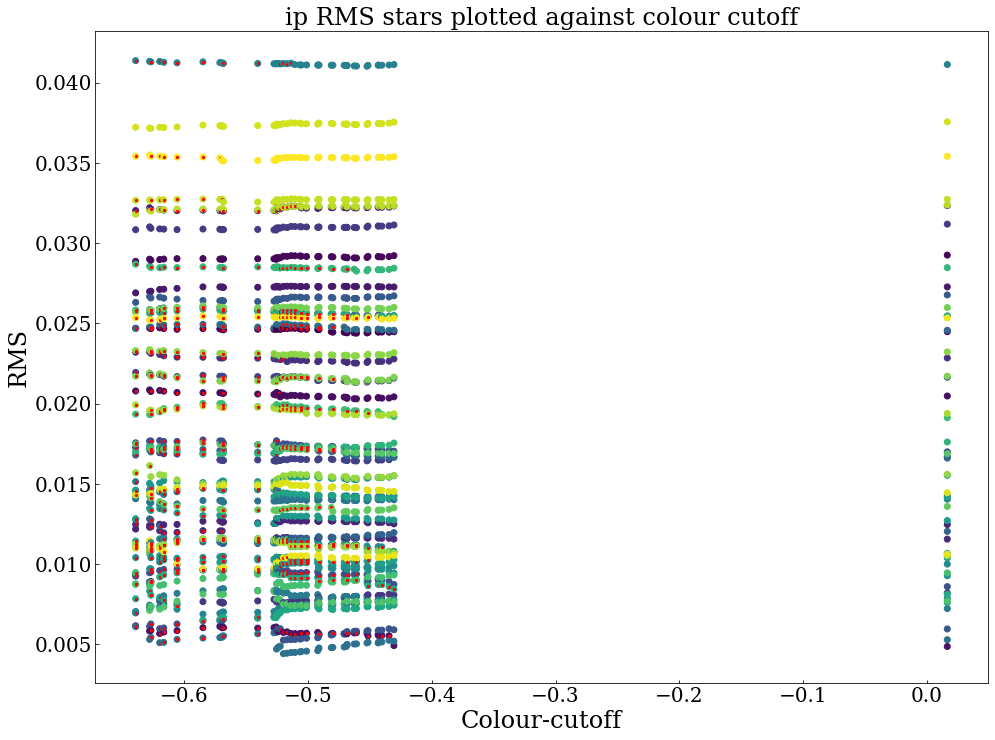

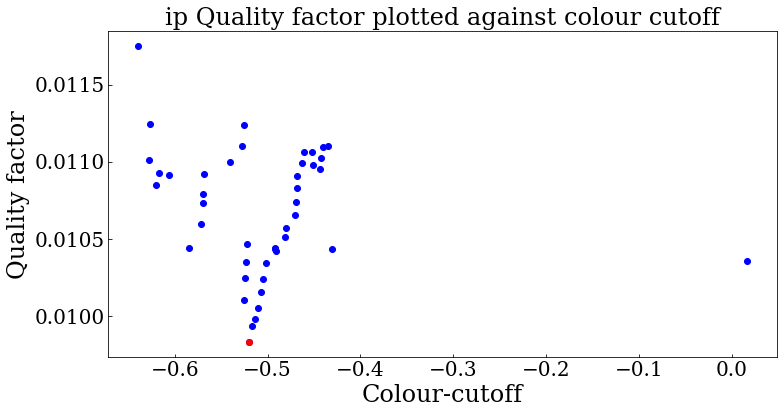

In [28]:
# First we try step xi) without radial distance weighting but just setting a max on the colours

c_range = {}
for f in filt:
    c_range[f] = np.sort(gaia_c[f])[int(len(gaia_c[f])/4):] #keep at least 25% of stars with 'low' colour
    #c_range[f] = np.sort(gaia_c[f])[1:]


col_cutoff = {}
for f in filt:
    #tmp1 = []
    tmp2 = []
    plt.figure(figsize=(16,12))
    for c in c_range[f]:
        wgt = copy.copy(weight2[f])
        c_mask = gaia_c[f] > c
        wgt[c_mask] = 0
        
        ALC_tmp = ALC_func(flux4[f],epoch[f], medflux2[f], wgt)
        ALCnormF = ((flux4[f].T/ALC_tmp).T)/medflux2[f]
        RMS_ALCnormF = np.sqrt(np.nanmean((ALCnormF-np.nanmean(ALCnormF,axis=0))**2,axis=0))
        plt.scatter([c]*len(flux4[f][0]),RMS_ALCnormF, c=range(len(flux4[f][0])))
        
        plt.scatter([c]*np.sum(c_mask),RMS_ALCnormF[c_mask], c='red',s=5)
        #tmp1.append(np.mean(RMS_ALCnormF[c_mask==False]))
        tmp2.append(np.mean((RMS_ALCnormF*wgt))/np.mean(wgt))
    
    colcutoff_index = np.where(tmp2==np.min(tmp2))[0]
    col_cutoff[f] = c_range[f][colcutoff_index]
    
    #plt.yscale('log')
    plt.title(f+" RMS stars plotted against colour cutoff")
    plt.ylabel("RMS")
    plt.xlabel("Colour-cutoff")
    plt.show()
    #plt.figure(figsize=(12,6))
    #plt.scatter(c_range[f],tmp1,c='b')
    #plt.scatter(c_range[f][colcutoff_index],np.array(tmp1)[colcutoff_index],c='r')
    #plt.title(f+" Mean of star RMS plotted against colour cutoff")
    #plt.ylabel("Mean RMS")
    #plt.xlabel("Colour-cutoff")
    #plt.show()

    plt.figure(figsize=(12,6))
    plt.scatter(c_range[f],tmp2,c='b')
    plt.scatter(c_range[f][colcutoff_index],np.array(tmp2)[colcutoff_index],c='r')
    plt.title(f+" Quality factor plotted against colour cutoff")
    plt.ylabel("Quality factor")
    plt.xlabel("Colour-cutoff")
    plt.show()

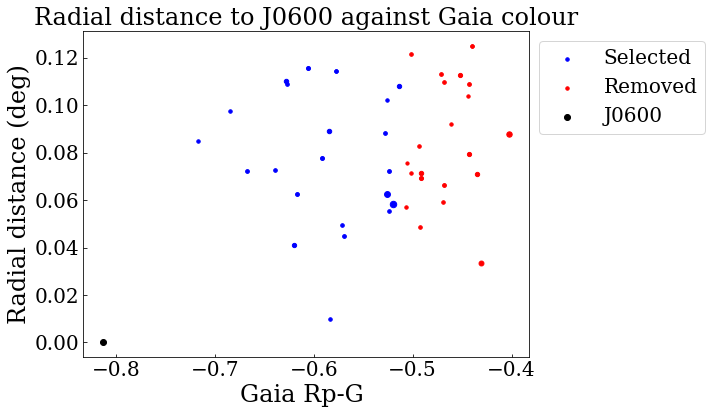

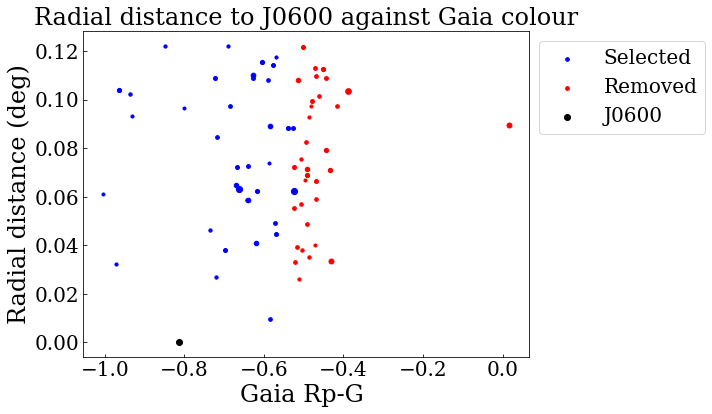

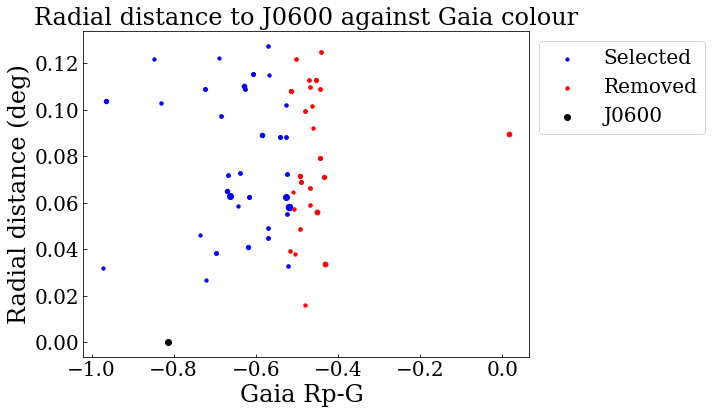

In [29]:
c_mask = {}
for f in filt:
    c_mask[f] = gaia_c[f] <= col_cutoff[f]


for f in filt:
    for s in np.arange(len(gaia_c[f]))[c_mask[f]]:
        plt.scatter(gaia_c[f][s],d_J0600[f][s],c='b',s=1e0*(medflux2[f][s])**(1/4))
    plt.scatter(gaia_c[f][s],d_J0600[f][s],c='b',s=1e0*(medflux2[f][s])**(1/4),label='Selected')
    for s in np.arange(len(gaia_c[f]))[c_mask[f]==False]:
        plt.scatter(gaia_c[f][s],d_J0600[f][s],c='r',s=1e0*(medflux2[f][s])**(1/4))
    plt.scatter(gaia_c[f][s],d_J0600[f][s],c='r',s=1e0*(medflux2[f][s])**(1/4),label='Removed')
    plt.scatter(J0600_c,[0],c='black',label='J0600')
    plt.title("Radial distance to J0600 against Gaia colour")
    plt.ylabel("Radial distance (deg)")
    plt.xlabel("Gaia Rp-G ")
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.show()
    
final_weight = {}
ALC_final = {}
for f in filt:
    final_weight[f] = copy.copy(weight2[f])
    final_weight[f][c_mask[f]==False] = 0
    
    ALC_final[f] = ALC_func(flux4[f], epoch[f], medflux2[f], final_weight[f])

In [30]:
flux5 = {}
fluxerr5 = {}
medflux3 = {}
for f in filt:
    flux5[f] = ((flux4[f].T)[c_mask[f]]).T
    fluxerr5[f] = ((fluxerr4[f].T)[c_mask[f]]).T
    medflux3[f] = np.nanmedian((flux5[f].T)/ALC_final[f].T,axis=1)

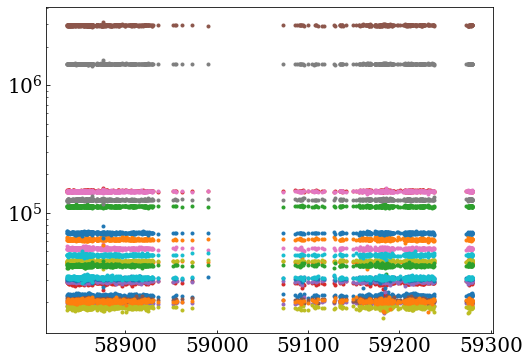

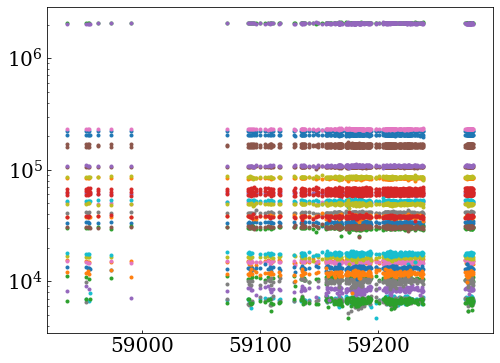

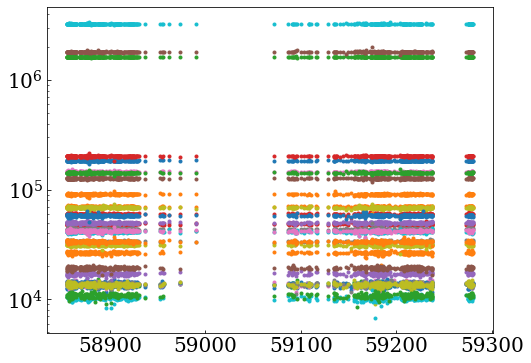

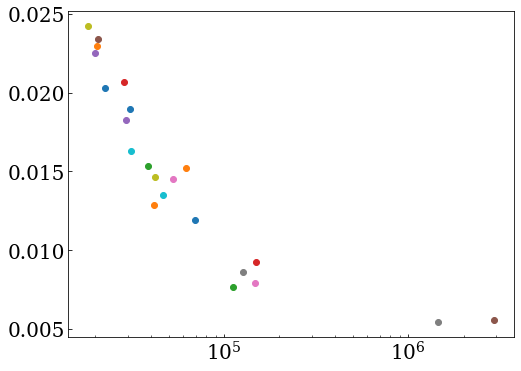

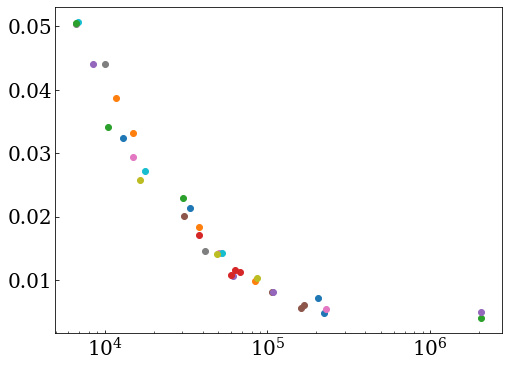

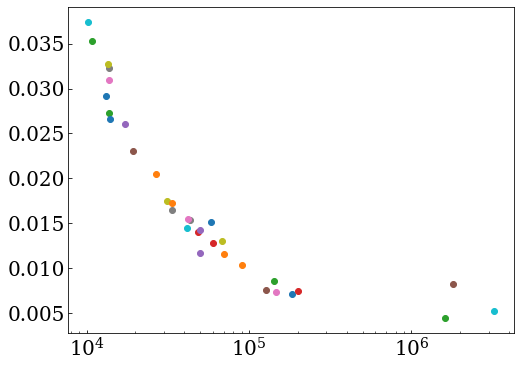

In [31]:
for f in filt:
    for s in range(len(flux5[f][0])):
        plt.errorbar(epoch[f], (flux5[f][:,s]/ALC_final[f]),fmt='.')
    plt.yscale('log')
    plt.show()

for f in filt:
    for s in range(len(flux5[f][0])):
        plt.scatter(np.nanmedian(flux5[f][:,s]/ALC_final[f]),
                    RMS((flux5[f][:,s]/ALC_final[f])/np.nanmedian(flux5[f][:,s]/ALC_final[f])))
    plt.xscale('log')
    plt.show()

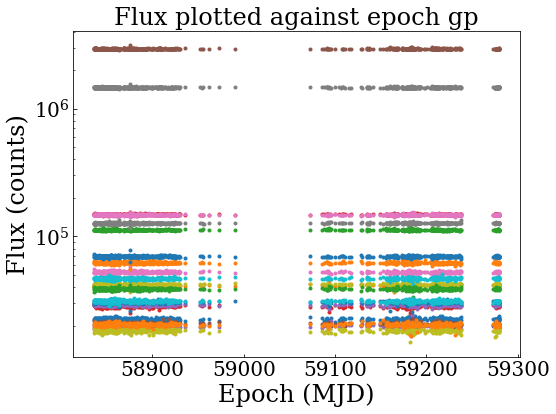

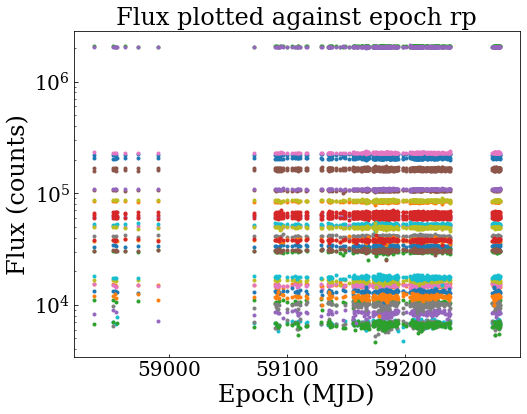

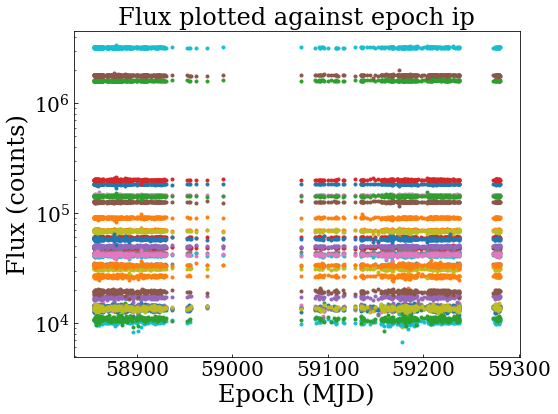

In [32]:
for f in filt:
#    plt.figure(figsize=(12,8))
    for s in range(len(flux5[f][0])):
        plt.errorbar(epoch[f],(flux5[f][:,s]/ALC_final[f]),fmt='.')
    plt.yscale('log')
    plt.title("Flux plotted against epoch "+f)
    plt.xlabel('Epoch (MJD)')
    plt.ylabel('Flux (counts)')
    #plt.axis(ymax=6e6)
    plt.show()

<ipython-input-15-539780b1a58e>:7: RuntimeWarning: invalid value encountered in sqrt
  return a*np.sqrt((1/F) + (b/(F**2)) + c)


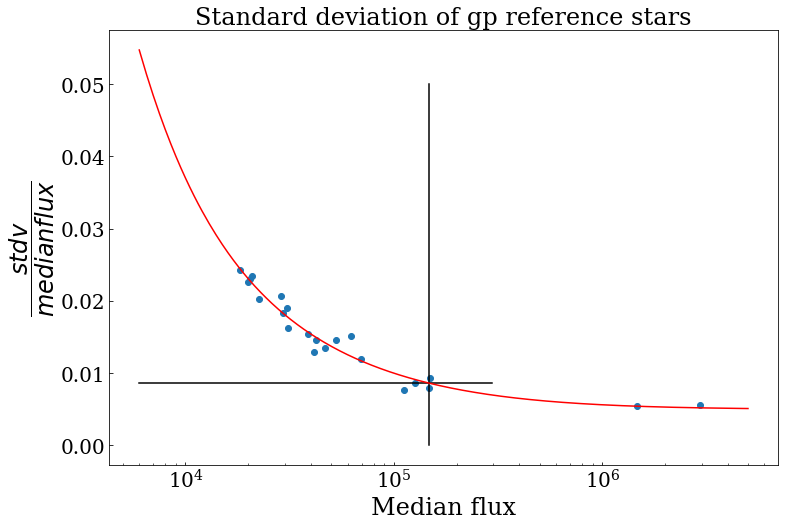

[2.61863989e+00 9.59135152e+03 3.58492114e-06]


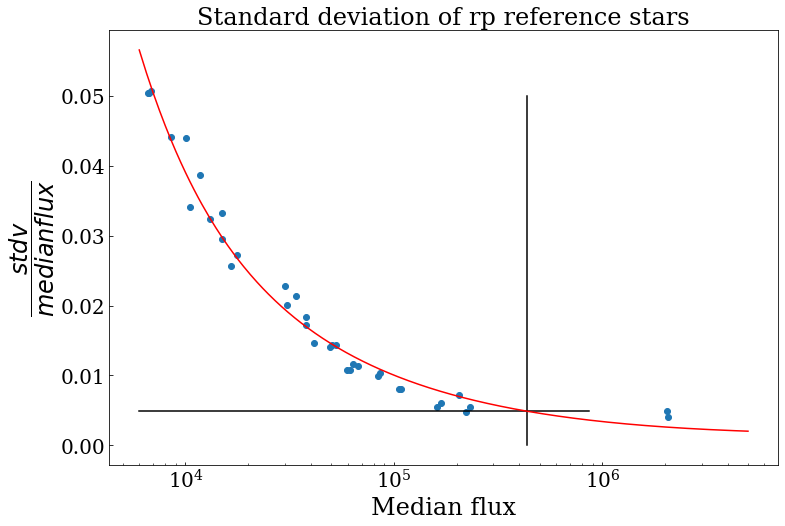

[3.04419709e+00 6.42256452e+03 2.41716918e-07]


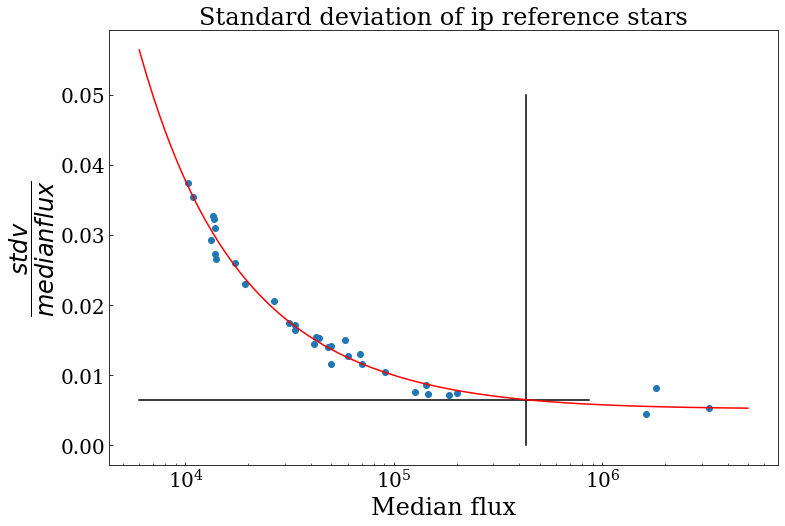

[2.56066061e+00 1.13023989e+04 4.08218899e-06]


In [52]:
est_errpar = {}
for f in filt:
    popt,pcov=optimize.curve_fit(starRMS_model, medflux3[f],np.nanstd((flux5[f].T/ALC_final[f]).T/medflux3[f],axis=0))
    est_errpar[f] = popt

x = np.linspace(6e3,5e6,10000)
for f in filt:
    plt.figure(figsize=(12,8))
    plt.plot([np.nanmedian(J0600_flux[f])]*2,[0.0,0.05],c='black')
    plt.plot([6e3,2*np.nanmedian(J0600_flux[f])],[starRMS_model(np.nanmedian(J0600_flux[f]),*est_errpar[f])]*2,c='black')
    plt.plot(x,starRMS_model(x,*est_errpar[f]),c='r',linestyle='-')
    plt.scatter(medflux3[f],np.nanstd((flux5[f].T/ALC_final[f]).T/medflux3[f],axis=0))
    plt.xscale('log')
    plt.title("Standard deviation of "+f+" reference stars")
    plt.ylabel('$\dfrac{stdv}{median flux}$')
    plt.xlabel('Median flux')
    #plt.axis(ymax=6e6)
    plt.show()
    print (est_errpar[f])

In [34]:
def zeropoint(m,a):
    return m + a

filt2 = ['gp','rp']
RMS_tmp = {}
for f in filt:
    tmp = []
    for s in range(len(flux5[f][0])):
        M = -2.5*np.log10(flux5[f][:,s]/ALC_final[f])
        tmp.append(RMS(M))
    RMS_tmp[f] = np.array(tmp)

In [35]:

ZP_real = {}

# A zeropoint for each epoch
#for f in filt2:
#    tmp = []
#    for e in range(len(epoch[f])):
#        nonNaN = np.isnan(flux5[f][e]) == False
#        M = -2.5*np.log10(flux5[f][e]/ALC_final[f][e])[nonNaN]
        
#        popt, pcov = optimize.curve_fit(zeropoint, M, gaia_mag[f][c_mask[f]][nonNaN])#,sigma=RMS_tmp[f][nonNaN], absolute_sigma=True)
        
#        tmp.append(popt[0])
#        plt.scatter(gaia_mag[f][c_mask[f]][nonNaN], M)
#    plt.show()
#    ZP_real[f] = np.array(tmp)

# An overall zeropoint
for f in filt2:
    tmp = []
    M = -2.5*np.log10(np.nanmedian((flux5[f].T/ALC_final[f]).T,axis=0))
    popt, pcov = optimize.curve_fit(zeropoint, M, gaia_mag[f][c_mask[f]],sigma=1/RMS_tmp[f])#, absolute_sigma=True)

    ZP_real[f] = np.array(popt[0])
    #plt.figure(figsize=(6,6))
    #plt.plot(np.linspace(np.min(gaia_mag[f]),np.max(gaia_mag[f])),np.linspace(np.min(gaia_mag[f]),np.max(gaia_mag[f])))
    #plt.scatter(gaia_mag[f][c_mask[f]], -2.5*np.log10(medflux3[f])+ZP_real[f])
    #plt.show()
ZP_real['ip'] = 0

In [36]:
#for f in filt2:
#    plt.figure(figsize=(16,12))
#    for s in range(len(flux5[f][0])):
#        plt.plot([np.min(epoch[f]),np.max(epoch[f])],[gaia_mag[f][c_mask[f]][s]]*2,c='black',linestyle='--')
#        plt.errorbar(epoch[f],-2.5*np.log10(flux5[f][:,s]/ALC_final[f])+ZP_real[f],fmt='--.')
#    plt.gca().invert_yaxis()
#    plt.show()

In [62]:
plot_c = {'gp':'g','ip':'indianred','rp':'r','up':'purple'}

J0600_mag = {}
J0600_magerr = {}
for f in filt:
    J0600_mag[f] = -2.5*np.log10(J0600_flux[f]/ALC_final[f])  + ZP_real[f]
    #J0600_magerr[f] = (2.5/np.log(10)) * (J0600_fluxerr[f]/J0600_flux[f])
    J0600_magerr[f] = (2.5/np.log(10)) * (starRMS_model(J0600_flux[f]/ALC_final[f],*est_errpar[f]))

ASTEP = np.array([ascii.read("../J0600_mag/ASTEP_R.txt")['EPOCH'],ascii.read("../J0600_mag/ASTEP_R.txt")['MAG'],\
                  ascii.read("../J0600_mag/ASTEP_R.txt")['MAGERR']])

#Find correction factor to connect ASTEP to LCOGT (very rough though)
#print (len(epoch['rp'][epoch['rp']<59000]))
print ("Days differnce between \"connection points\" = {:.3f}"\
       .format(ASTEP[0][0] - epoch['rp'][epoch['rp']<59000][-1]))
#print (J0600_mag['rp'][7])
ASTEP[1] = ASTEP[1] - (ASTEP[1][0] - J0600_mag['rp'][7])



ZP = {}
for f in filt:
    #ZP[f] = J0600_mag[f][-1]
    #ZP[f] = np.nanmin(J0600_mag[f])
    #ZP[f] = np.nanmin(J0600_mag[f][epoch[f]>59250])
    ZP[f] = np.nanmedian(J0600_mag[f][ (epoch[f]>59209)*(epoch[f]<59210.5) ])
J0600_gaiamag['ip'] = np.nanmin(J0600_mag['ip'])

ASTEP_ZP = ZP['rp']

Days differnce between "connection points" = 9.236


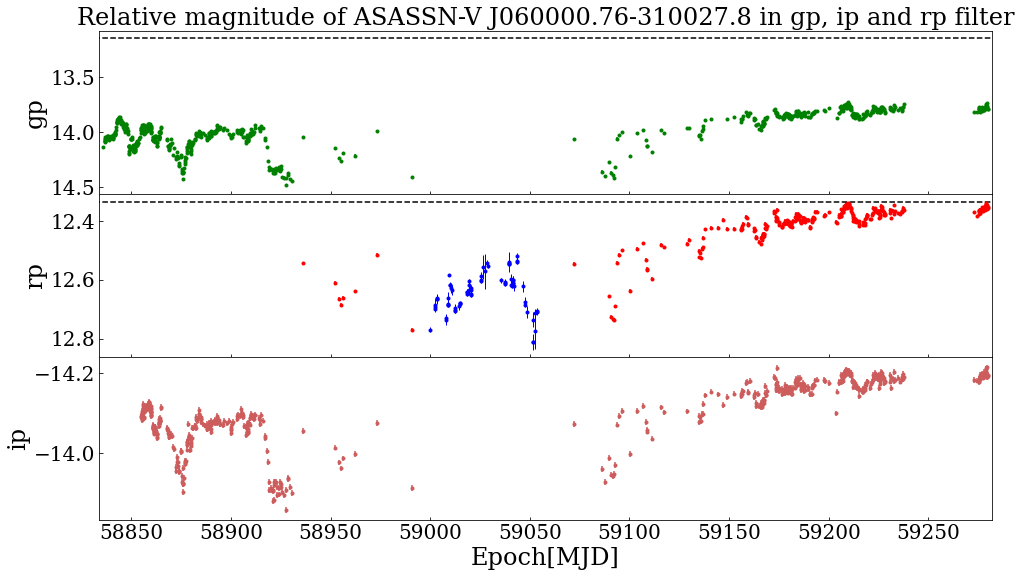

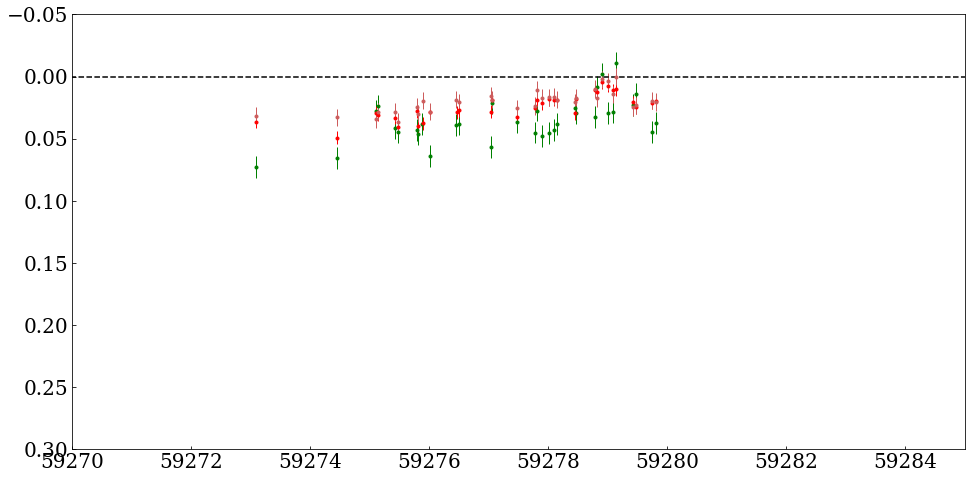

In [75]:

fig, axs = plt.subplots(len(filt), sharex=True, gridspec_kw={'hspace': 0})
#fig.title('Magnitude of J0600 in gp and rp filter ')
fig.set_figheight(9)
fig.set_figwidth(16)
axs[0].set_title('Relative magnitude of ASASSN-V J060000.76-310027.8 in gp, ip and rp filter')
for i in range(len(filt)):
    if filt[i] != 'ip':
        axs[i].plot([0,1e6],[J0600_gaiamag[filt[i]],J0600_gaiamag[filt[i]]],c='black',linestyle='dashed')
    #axs[i].plot([0,1e6],[ZP[filt[i]],ZP[filt[i]]],c='black',linestyle='dashed')
    axs[i].errorbar(epoch[filt[i]], J0600_mag[filt[i]], yerr=J0600_magerr[filt[i]], fmt='.',c=plot_c[filt[i]])
    axs[i].set_ylabel(filt[i])
    axs[i].invert_yaxis()
    if filt[i] == 'rp':
        axs[i].errorbar(ASTEP[0], ASTEP[1], yerr=ASTEP[2], fmt='.',c='b',linewidth=1)
    
    # shows at what epoch images are removed!
    #for e in range(len(rawepoch[filt[i]][ge_mask[filt[i]]==False])):#rm later
    #    axs[i].plot([rawepoch[filt[i]][ge_mask[filt[i]]==False][e]]*2,
    #                [np.nanmean(J0600_mag[filt[i]])-.2,0.3+np.nanmean(J0600_mag[filt[i]])], c='black')
        
    #measurement period astep telescope
    #axs[i].plot([58999,59052],[np.nanmean(J0600_mag[filt[i]])]*2,c='r',linestyle='--')
axs[i].set_xlabel("Epoch[MJD]")
axs[i].set_xlim([epoch['gp'][0]-2,epoch['gp'][-1]+2])
#axs[i].set_xlim([59203,59215])
#axs[i].set_xlim([58989,59080])


# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()
plt.show()


plt.figure(figsize=(16,8))
plt.plot([0,1e6],[0,0],c='black',linestyle='dashed')
for f in filt:
    if f != 'gp':
        plt.errorbar(epoch[f], J0600_mag[f]-J0600_gaiamag[f],yerr=J0600_magerr[f], fmt='.',c=plot_c[f],linewidth=1)
    else:
        plt.errorbar(epoch[f], J0600_mag[f]-J0600_gaiamag[f]-.6,yerr=J0600_magerr[f], fmt='.',c=plot_c[f],linewidth=1)
plt.errorbar(ASTEP[0],ASTEP[1]-ASTEP_ZP, yerr=ASTEP[2], fmt='.', c='b',linewidth=1)
plt.gca().invert_yaxis()
plt.xlim([epoch['gp'][0]-2,epoch['gp'][-1]+2])
plt.xlim(59270,59285)
plt.ylim(0.3,-0.05)
plt.show()

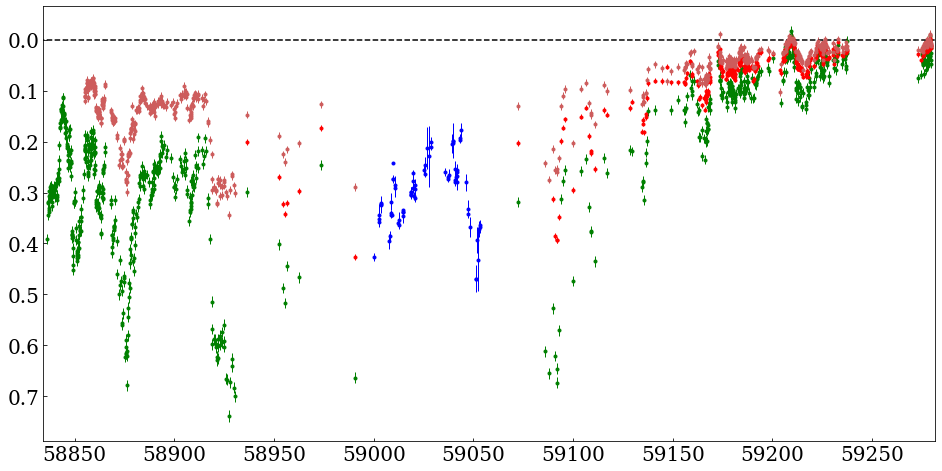

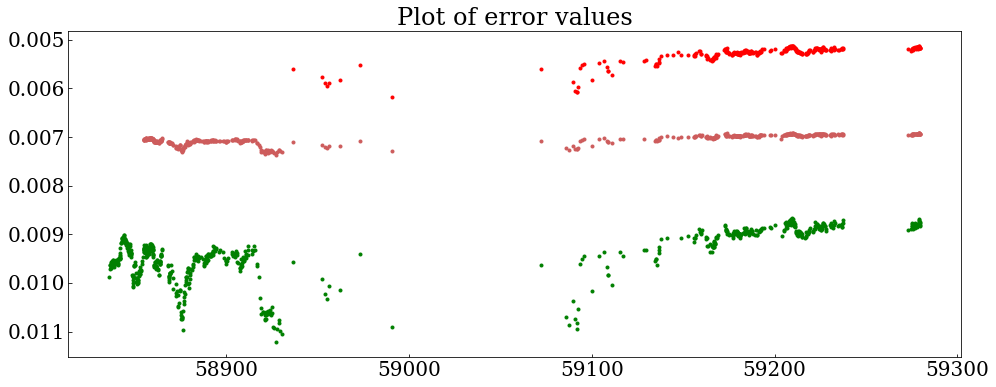

In [64]:
plt.figure(figsize=(16,8))
plt.plot([0,1e6],[0,0],c='black',linestyle='dashed')
for f in filt:
    plt.errorbar(epoch[f], J0600_mag[f]-ZP[f],yerr=J0600_magerr[f], fmt='.',c=plot_c[f],linewidth=1)
plt.errorbar(ASTEP[0],ASTEP[1]-ASTEP_ZP, yerr=ASTEP[2], fmt='.', c='b',linewidth=1)
plt.gca().invert_yaxis()
plt.xlim([epoch['gp'][0]-2,epoch['gp'][-1]+2])
#plt.xlim(59150,59280)
#plt.xlim(59205,59215)
#plt.ylim(0.25,-0.05)
plt.show()


plt.figure(figsize=(16,6))
for f in filt:
    plt.errorbar(epoch[f],J0600_magerr[f],fmt='.',c=plot_c[f])
#plt.yscale('log')
plt.gca().invert_yaxis()
plt.title("Plot of error values")
plt.show()


In [40]:
for f in filt:
    print (np.min(epoch[f]), np.max(epoch[f]))
    
    #12-18-2019 till 07-03-2021
    #01-07-2020 till 07-03-2021
    #03-28-2020 till 07-03-2021

58835.8812448 59279.8092037
58936.404609 59279.8108106
58855.095569 59279.8099784


In [41]:
# Extract the J0600 data to a file

for f in filt:
    filepath = "../J0600_mag/LCOGT_"+f+".txt"
    filecontent = Table([epoch[f], airmass[f], J0600_mag[f], J0600_magerr[f], J0600_mag[f]-ZP[f]],\
                       names=["EPOCH","AIRMASS","MAG","MAGERR", "NORMMAG"])
    ascii.write(filecontent, filepath, overwrite=True)

filepath = "../J0600_mag/ASTEP_norm_"+f+".txt"
filecontent = Table([ASTEP[0], ASTEP[1]-ZP['rp'], ASTEP[2]],\
                    names=["EPOCH","MAG","MAGERR"])
ascii.write(filecontent, filepath, overwrite=True)

# Make the $\Delta gp$ vs $\Delta ip$ vs $\Delta rp$ plots

In [42]:
#Use Interpolate to map rp datapoints on gp
#Use color of datapoints in plot to signal epoch
from scipy import interpolate

f1 = interpolate.interp1d(epoch['ip'],J0600_mag['ip'])
f2 = interpolate.interp1d(epoch['rp'],J0600_mag['rp'])

m1 = epoch['gp'] > np.min(epoch['ip']) # or 59050 as max epoch
m2 = epoch['gp'] < np.max(epoch['ip'])
J0600_ip_interp = f1(epoch['gp'][m1*m2])

m3 = epoch['gp'] > np.min(epoch['rp']) # or 59050 as max epoch
m4 = epoch['gp'] < np.max(epoch['rp'])
J0600_rp_interp = f2(epoch['gp'][m3*m4])



605


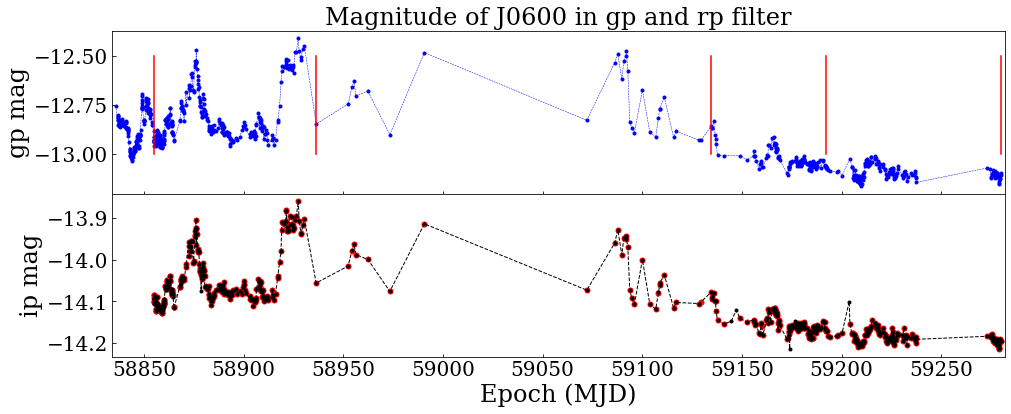

In [43]:
# Plot the interpolated data to test if it worked
# Black dots & line are original ip data, red is interpolated data on gp epoch's

fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
fig.set_figheight(6)
fig.set_figwidth(16)
axs[0].set_title('Magnitude of J0600 in gp and rp filter')
axs[0].plot(epoch['gp'],J0600_mag['gp'],marker='.',linestyle='dashed',linewidth=0.5,c='b')
axs[0].set_ylabel("gp mag")

axs[1].plot(epoch['gp'][m1*m2], J0600_ip_interp, marker='o',linestyle='',c='r',markersize=5)
axs[1].plot(epoch['ip'],J0600_mag['ip'],marker='.',linestyle='dashed',linewidth=1,c='black',markersize=6)
axs[1].set_ylabel("ip mag")
axs[1].set_xlabel("Epoch (MJD)")
axs[1].set_xlim(np.min(epoch['gp'])-2,2+np.max(epoch['gp']))

print (len(J0600_ip_interp))

parts = [0,290,320,453,604]
for i in parts:
    axs[0].plot([epoch['gp'][m1*m2][i]]*2,[-13,-12.5],c='r')

# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()

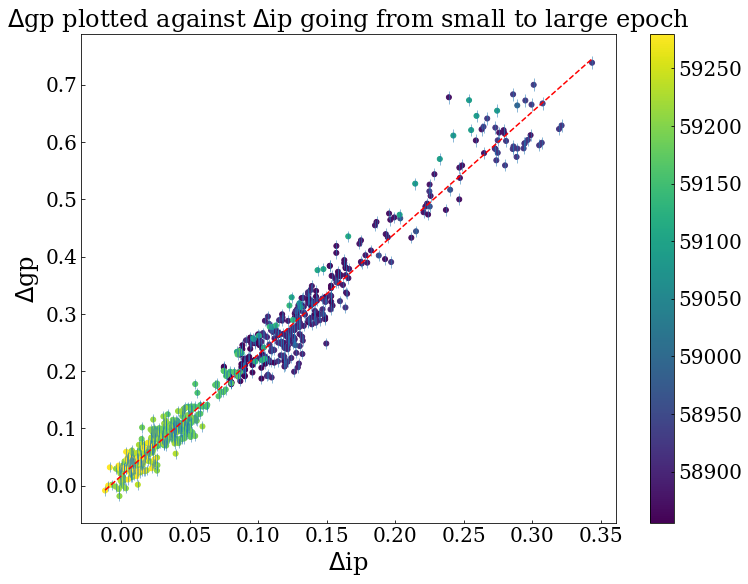

In [44]:
def linear2(x,a,b):
    return x*a + b
popt, pcov = optimize.curve_fit(linear2, J0600_ip_interp-ZP['ip'],\
                                (J0600_mag['gp'][m1*m2]-ZP['gp']))
popt2, pcov2 = optimize.curve_fit(linear2, J0600_rp_interp-ZP['rp'],\
                                (J0600_mag['gp'][m3*m4]-ZP['gp']))

plt.figure(figsize=(12,9))
x = np.linspace(np.nanmin((J0600_ip_interp-ZP['ip'])),np.nanmax((J0600_ip_interp-ZP['ip'])),100)
#ax=plt.axes()
#ax.set(facecolor='orange')
plt.plot(x,linear2(x,*popt),c='r',linestyle='dashed')
plt.errorbar((J0600_ip_interp-ZP['ip']),(J0600_mag['gp'][m1*m2]-ZP['gp']),
             yerr=J0600_magerr['gp'][m1*m2], fmt='.',markersize=0,linewidth=0.51)
#sc = plt.scatter((J0600_ip_interp-ZP['ip'])[i:T],(J0600_mag['gp'][m1*m2]-ZP['gp'])[i:T],
#                c=(dotcolor)[i:T],marker='.',s=100)
sc = plt.scatter((J0600_ip_interp-ZP['ip']),(J0600_mag['gp'][m1*m2]-ZP['gp']),
                c=epoch['gp'][m1*m2] ,marker='.',s=100)
clb = plt.colorbar(sc)
    #plt.errorbar((J0600_gaiamag['rp']-J0600_rp_interp)[e],(J0600_gaiamag['gp']-J0600_mag['gp'][m1*m2])[e],
    #            fmt='o',c='black', alpha=dotcolor[e]*0.9+0.1)
plt.title("$\Delta$gp plotted against $\Delta$ip going from small to large epoch")
plt.xlabel("$\Delta$ip")
plt.ylabel("$\Delta$gp")
plt.show()


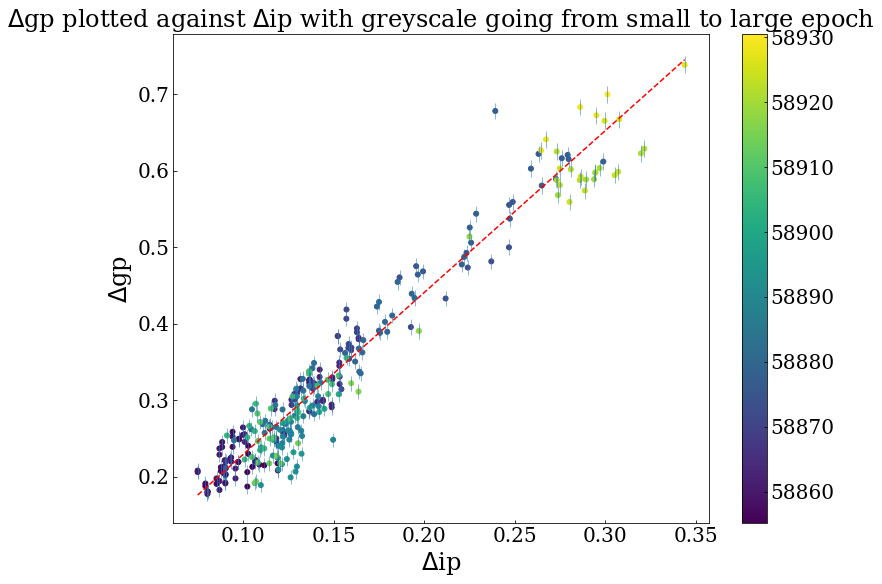

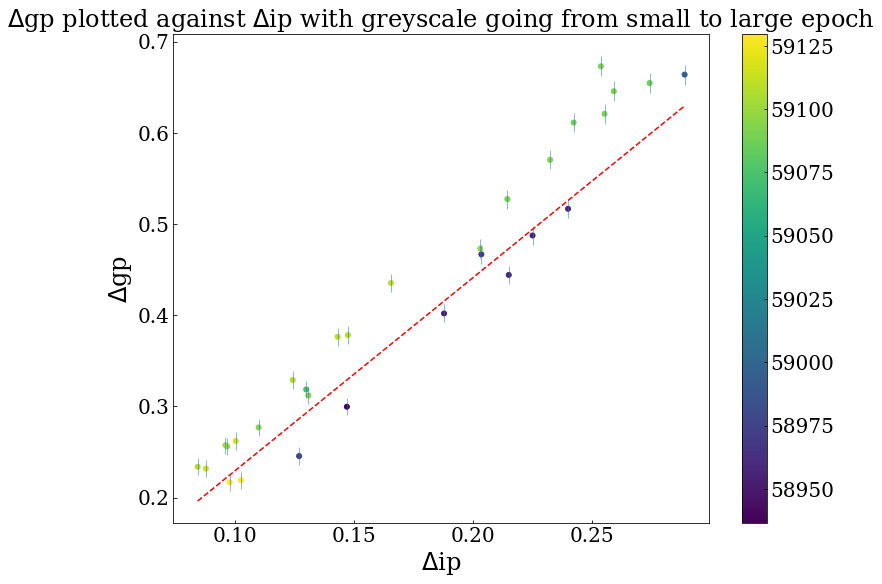

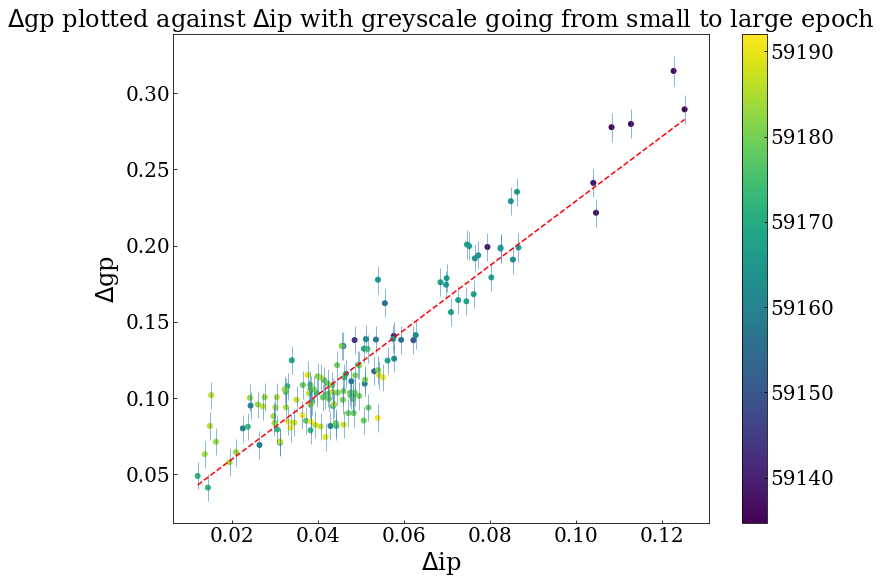

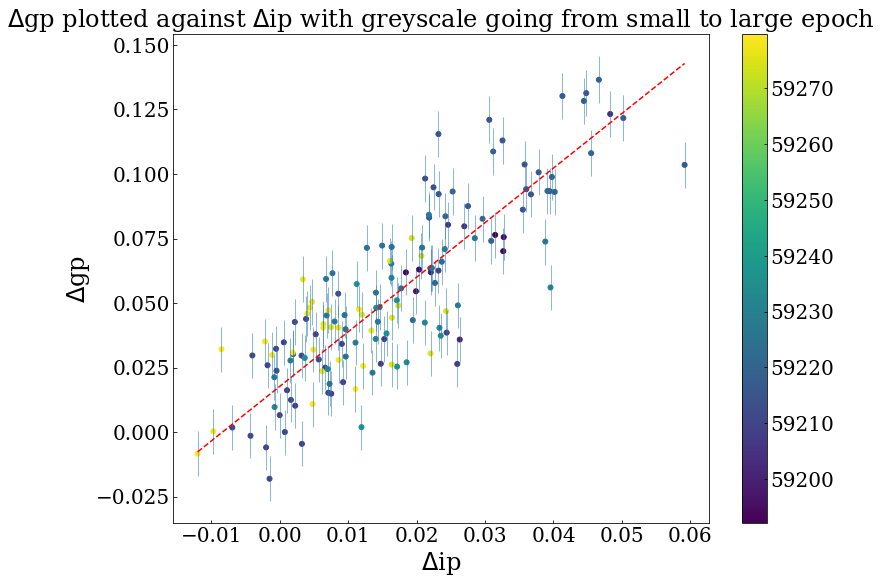

In [45]:
# Plot different parts of the lightcurve

for i,T in zip(parts[:-1], parts[1:]):
    dotcolor = (epoch['gp'][m1*m2]-epoch['gp'][m1*m2][i])/(epoch['gp'][m1*m2][T]-epoch['gp'][m1*m2][i])
    plt.figure(figsize=(12,9))
    x = np.linspace(np.nanmin((J0600_ip_interp-ZP['ip'])[i:T]),np.nanmax((J0600_ip_interp-ZP['ip'])[i:T]),100)
    #ax=plt.axes()
    #ax.set(facecolor='orange')
    plt.plot(x,linear2(x,*popt),c='r',linestyle='dashed')
    plt.errorbar((J0600_ip_interp-ZP['ip'])[i:T],(J0600_mag['gp'][m1*m2]-ZP['gp'])[i:T],
                 yerr=J0600_magerr['gp'][m1*m2][i:T], fmt='.',markersize=0,linewidth=0.51)
    #sc = plt.scatter((J0600_ip_interp-ZP['ip'])[i:T],(J0600_mag['gp'][m1*m2]-ZP['gp'])[i:T],
    #                c=(dotcolor)[i:T],marker='.',s=100)
    sc = plt.scatter((J0600_ip_interp-ZP['ip'])[i:T],(J0600_mag['gp'][m1*m2]-ZP['gp'])[i:T],
                    c=epoch['gp'][m1*m2][i:T] ,marker='.',s=100)
    clb = plt.colorbar(sc)
        #plt.errorbar((J0600_gaiamag['rp']-J0600_rp_interp)[e],(J0600_gaiamag['gp']-J0600_mag['gp'][m1*m2])[e],
        #            fmt='o',c='black', alpha=dotcolor[e]*0.9+0.1)
    plt.title("$\Delta$gp plotted against $\Delta$ip with greyscale going from small to large epoch")
    plt.xlabel("$\Delta$ip")
    plt.ylabel("$\Delta$gp")
    plt.show()

In [46]:
print (len(epoch['gp'][m3*m4]))

314


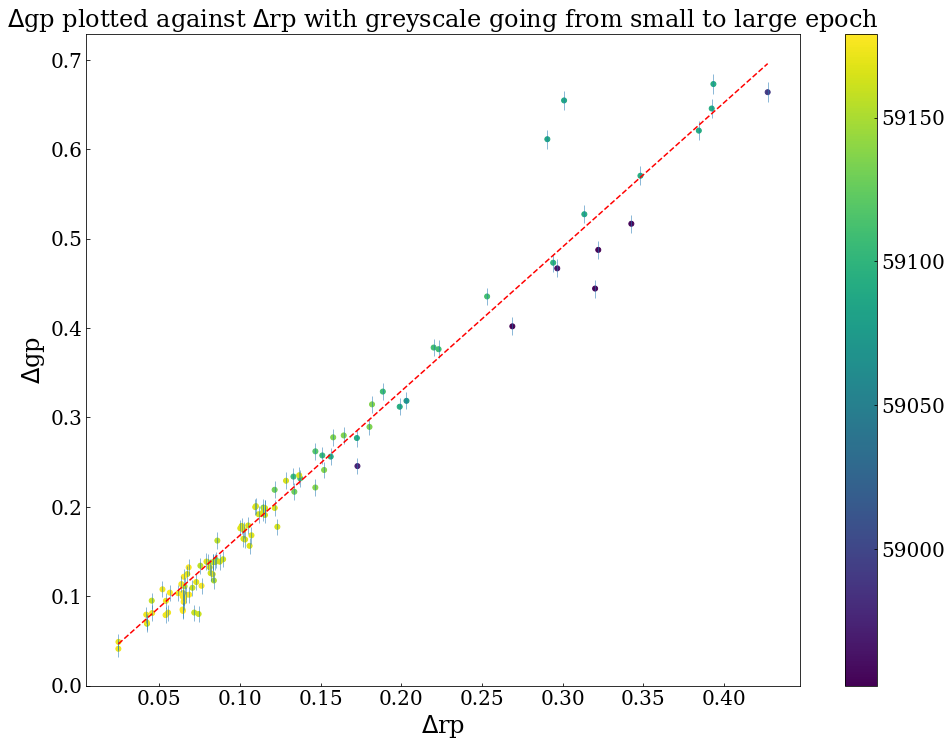

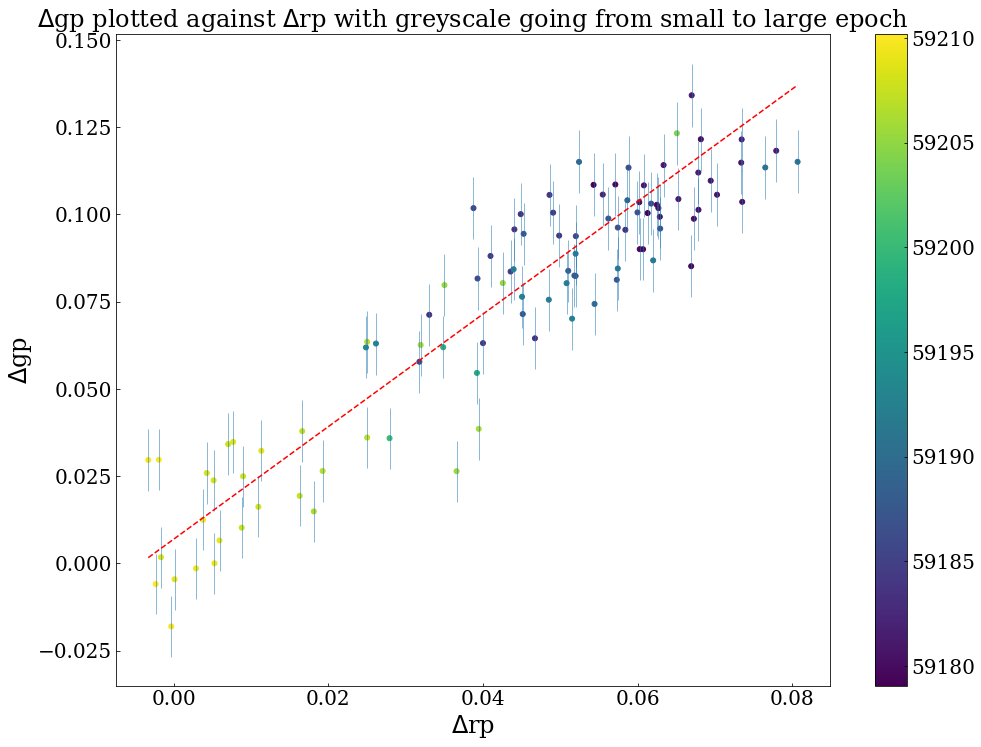

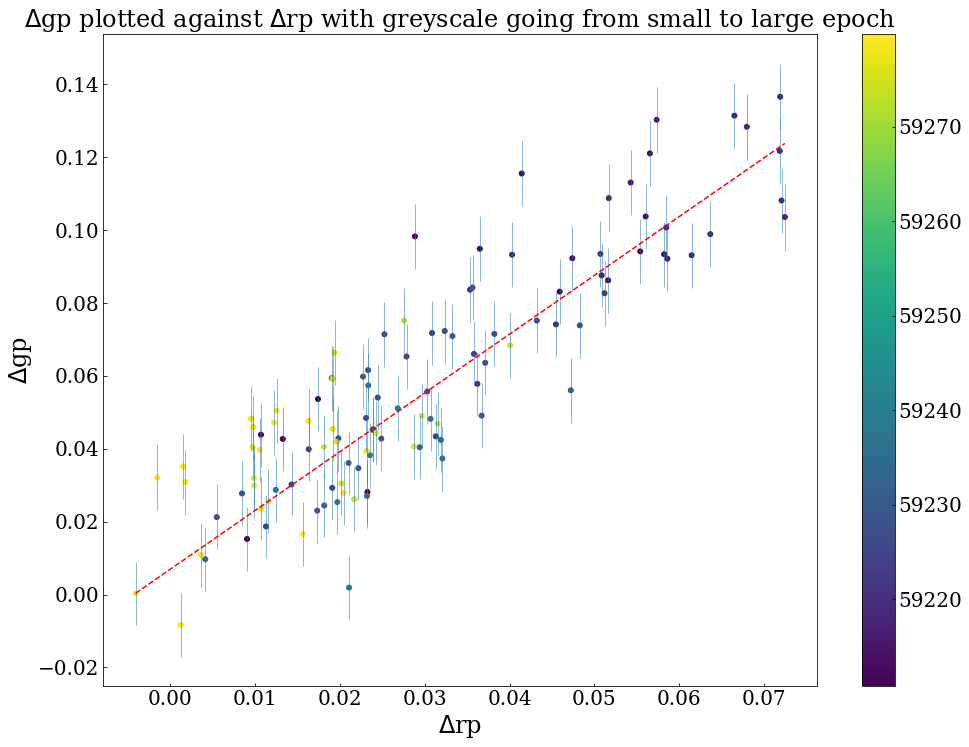

In [47]:
# Plot different parts of the lightcurve
parts2 = [0,100,200,314]

for i,T in zip(parts2[:-1], parts2[1:]):
    plt.figure(figsize=(16,12))
    x = np.linspace(np.nanmin((J0600_rp_interp-ZP['rp'])[i:T]),np.nanmax((J0600_rp_interp-ZP['rp'])[i:T]),100)
    #ax=plt.axes()
    #ax.set(facecolor='orange')
    plt.plot(x,linear2(x,*popt2),c='r',linestyle='dashed')
    plt.errorbar((J0600_rp_interp-ZP['rp'])[i:T],(J0600_mag['gp'][m3*m4]-ZP['gp'])[i:T],
                 yerr=J0600_magerr['gp'][m3*m4][i:T], fmt='.',markersize=0,linewidth=0.51)
    #sc = plt.scatter((J0600_ip_interp-ZP['ip'])[i:T],(J0600_mag['gp'][m1*m2]-ZP['gp'])[i:T],
    #                c=(dotcolor)[i:T],marker='.',s=100)
    sc = plt.scatter((J0600_rp_interp-ZP['rp'])[i:T],(J0600_mag['gp'][m3*m4]-ZP['gp'])[i:T],
                    c=epoch['gp'][m3*m4][i:T] ,marker='.',s=100)
    clb = plt.colorbar(sc)
        #plt.errorbar((J0600_gaiamag['rp']-J0600_rp_interp)[e],(J0600_gaiamag['gp']-J0600_mag['gp'][m1*m2])[e],
        #            fmt='o',c='black', alpha=dotcolor[e]*0.9+0.1)
    plt.title("$\Delta$gp plotted against $\Delta$rp with greyscale going from small to large epoch")
    plt.xlabel("$\Delta$rp")
    plt.ylabel("$\Delta$gp")
    plt.show()